In [1]:
import os
import glob
import json
import random
from pathlib import Path
from difflib import SequenceMatcher

import cv2
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from IPython.display import display
import matplotlib
from matplotlib import pyplot, patches

In [2]:
#/kaggle/input/sroie-tesing/

sroie_folder_path = Path('E:/Model/archive/SROIE2019')
example_file = Path('E:/Model/archive/SROIE2019/test/box/X51005365187.txt')

In [3]:
def read_bbox_and_words(path: Path):
    bbox_and_words_list = []

    with open(path, 'r', errors='ignore') as f:
        for line in f.read().splitlines():
            if len(line) == 0:
                continue

            split_lines = line.split(",")

            bbox = np.array(split_lines[0:8], dtype=np.int32)
            text = ",".join(split_lines[8:])
            bbox_and_words_list.append([path.stem, *bbox, text])
    
    df = pd.DataFrame(
        bbox_and_words_list, 
        columns=['filename', 'x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'line']
    )
    int_cols = ['x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3']
    df[int_cols] = df[int_cols].astype(np.int16)
    df = df.drop(columns=['x1', 'y1', 'x3', 'y3'])

    return df


In [4]:
bbox_file_path = sroie_folder_path / "test/box" / example_file
print("File content-")
#!head -n 5 "{bbox_file_path}"


print("File content-")
with open(bbox_file_path, 'r', errors='ignore') as f:
    for _ in range(5):
        print(f.readline().rstrip())

        
bbox = read_bbox_and_words(path=bbox_file_path)
print("\nDataframe-")
bbox.head(5)

File content-
File content-
17,35,371,35,371,91,17,91,3-1707067
222,115,511,115,511,143,222,143,F&P PHARMACY
274,148,457,148,457,174,274,174,(002309592-P)
204,183,529,183,529,210,204,210,NO.20. GROUND FLOOR,
99,218,632,218,632,244,99,244,JALAN BS 10/6 TAMAN BUKIT SERDANG,

Dataframe-


filename   x0   y0   x2   y2                                line
0  X51005365187   17   35  371   91                           3-1707067
1  X51005365187  222  115  511  143                        F&P PHARMACY
2  X51005365187  274  148  457  174                       (002309592-P)
3  X51005365187  204  183  529  210                NO.20. GROUND FLOOR,
4  X51005365187   99  218  632  244  JALAN BS 10/6 TAMAN BUKIT SERDANG,

In [5]:
def read_entities(path: Path):
  with open(path, 'r') as f:
    data = json.load(f)

  dataframe = pd.DataFrame([data])
  return dataframe


<h1>Example</h1>

In [6]:
entities_file_path = Path(f"E:/Model/archive/SROIE2019/test/entities/{example_file.name}")

print("== File content ==")
with open(entities_file_path, "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        print(line.strip())
        if i == 9: break

entities = read_entities(path=entities_file_path)
print("\n\n== Dataframe ==")
entities


== File content ==
{
"company": "F&P PHARMACY",
"date": "02/03/2018",
"address": "NO.20. GROUND FLOOR, JALAN BS 10/6 TAMAN BUKIT SERDANG, SEKSYEN 10, 43300 SERI KEMBANGAN. SELANGOR DARUL EHSAN",
"total": "31.90"
}


== Dataframe ==


company        date  \
0  F&P PHARMACY  02/03/2018   

                                             address  total  
0  NO.20. GROUND FLOOR, JALAN BS 10/6 TAMAN BUKIT...  31.90

<h1>Assign labels to words using the entities data</h1>

In [7]:


# Assign a label to the line by checking the similarity of the line and all the entities
def assign_line_label(line: str, entities: pd.DataFrame):
    line_set = line.replace(",", "").strip().split()
    for i, column in enumerate(entities):
        entity_values = entities.iloc[0, i].replace(",", "").strip()
        entity_set = entity_values.split()
        
        
        matches_count = 0
        for l in line_set:
            if any(SequenceMatcher(a=l, b=b).ratio() > 0.8 for b in entity_set):
                matches_count += 1
            
            if (column.upper() == 'ADDRESS' and (matches_count / len(line_set)) >= 0.5) or \
               (column.upper() != 'ADDRESS' and (matches_count == len(line_set))) or \
               matches_count == len(entity_set):
                return column.upper()

    return "O"


line = bbox.loc[1,"line"]
label = assign_line_label(line, entities)
print("Line:", line)
print("Assigned label:", label)

Line: F&P PHARMACY
Assigned label: COMPANY


In [8]:
def assign_labels(words: pd.DataFrame, entities: pd.DataFrame):
    max_area = {"TOTAL": (0, -1), "DATE": (0, -1)}  # Value, index
    already_labeled = {"TOTAL": False,
                       "DATE": False,
                       "ADDRESS": False,
                       "COMPANY": False,
                       "O": False
    }

    # Go through every line in words and assign it a label
    labels = []
    for i, line in enumerate(words['line']):
        label = assign_line_label(line, entities)

        already_labeled[label] = True
        if (label == "ADDRESS" and already_labeled["TOTAL"]) or \
           (label == "COMPANY" and (already_labeled["DATE"] or already_labeled["TOTAL"])):
            label = "O"

        # Assign to the largest bounding box
        if label in ["TOTAL", "DATE"]:
            x0_loc = words.columns.get_loc("x0")
            bbox = words.iloc[i, x0_loc:x0_loc+4].to_list()
            area = (bbox[2] - bbox[0]) + (bbox[3] - bbox[1])

            if max_area[label][0] < area:
                max_area[label] = (area, i)

            label = "O"

        labels.append(label)

    labels[max_area["DATE"][1]] = "DATE"
    labels[max_area["TOTAL"][1]] = "TOTAL"

    words["label"] = labels
    return words


# Example usage
bbox_labeled = assign_labels(bbox, entities)
bbox_labeled.head(15)

filename   x0   y0   x2   y2                                line  \
0   X51005365187   17   35  371   91                           3-1707067   
1   X51005365187  222  115  511  143                        F&P PHARMACY   
2   X51005365187  274  148  457  174                       (002309592-P)   
3   X51005365187  204  183  529  210                NO.20. GROUND FLOOR,   
4   X51005365187   99  218  632  244  JALAN BS 10/6 TAMAN BUKIT SERDANG,   
5   X51005365187  111  250  623  275   SEKSYEN 10, 43300 SERI KEMBANGAN,   
6   X51005365187  186  284  538  308                SELANGOR DARUL EHSAN   
7   X51005365187  251  316  484  339                     TEL 03-89599823   
8   X51005365187  182  351  346  378                          GST REG NO   
9   X51005365187  274  387  461  409                         TAX INVOICE   
10  X51005365187   34  434  127  457                              DOC NO   
11  X51005365187  227  434  390  458                          CS00110840   
12  X51005365187  476  433  535  463                               DATE:   
13  X51005365187  562  436  700  458                          02/03/2018   
14  X51005365187   33  468  131  492                             CASHIER   

      label  
0         O  
1   COMPANY  
2         O  
3   ADDRESS  
4   ADDRESS  
5   ADDRESS  
6   ADDRESS  
7         O  
8         O  
9         O  
10        O  
11        O  
12        O  
13     DATE  
14        O

In [9]:
def split_line(line: pd.Series):
  line_copy = line.copy()

  line_str = line_copy.loc["line"]
  words = line_str.split(" ")

  # Filter unwanted tokens
  words = [word for word in words if len(word) >= 1]

  x0, y0, x2, y2 = line_copy.loc[['x0', 'y0', 'x2', 'y2']]
  bbox_width = x2 - x0
  

  new_lines = []
  for index, word in enumerate(words):
    x2 = x0 + int(bbox_width * len(word)/len(line_str))
    line_copy.at['x0'] = x0
    line_copy.at['x2'] = x2
    line_copy.at['line'] = word
    new_lines.append(line_copy.to_list())
    x0 = x2 + 5 

  return new_lines


# Example usage
new_lines = split_line(bbox_labeled.loc[1])
print("Original row:")
display(bbox_labeled.loc[1:1,:])

print("Splitted row:")
pd.DataFrame(new_lines, columns=bbox_labeled.columns)

Original row:


filename   x0   y0   x2   y2          line    label
1  X51005365187  222  115  511  143  F&P PHARMACY  COMPANY

Splitted row:


filename   x0   y0   x2   y2      line    label
0  X51005365187  222  115  294  143       F&P  COMPANY
1  X51005365187  299  115  491  143  PHARMACY  COMPANY

In [10]:
from time import perf_counter
def dataset_creator(folder: Path):
  bbox_folder = folder / 'box'
  entities_folder = folder / 'entities'
  img_folder = folder / 'img'

  # Sort by filename so that when zipping them together
  # we don't get some other file (just in case)
  entities_files = sorted(entities_folder.glob("*.txt"))
  bbox_files = sorted(bbox_folder.glob("*.txt"))
  img_files = sorted(img_folder.glob("*.jpg"))

  data = []

  print("Reading dataset:")
  for bbox_file, entities_file, img_file in tqdm(zip(bbox_files, entities_files, img_files), total=len(bbox_files)):            
    # Read the files
    bbox = read_bbox_and_words(bbox_file)
    entities = read_entities(entities_file)
    image = Image.open(img_file)

    # Assign labels to lines in bbox using entities
    bbox_labeled = assign_labels(bbox, entities)
    del bbox

    # Split lines into separate tokens
    new_bbox_l = []
    for index, row in bbox_labeled.iterrows():
      new_bbox_l += split_line(row)
    new_bbox = pd.DataFrame(new_bbox_l, columns=bbox_labeled.columns)
    del bbox_labeled


    # Do another label assignment to keep the labeling more precise 
    for index, row in new_bbox.iterrows():
      label = row['label']

      if label != "O":
        entity_values = entities.iloc[0, entities.columns.get_loc(label.lower())]
        entity_set = entity_values.split()
        
        if any(SequenceMatcher(a=row['line'], b=b).ratio() > 0.7 for b in entity_set):
            label = "S-" + label
        else:
            label = "O"
      
      new_bbox.at[index, 'label'] = label

    width, height = image.size
  
    data.append([new_bbox, width, height])

  return data

In [11]:
dataset_train = dataset_creator(sroie_folder_path / 'train')
dataset_test = dataset_creator(sroie_folder_path / 'test')

Reading dataset:


100%|████████████████████████████████████| 626/626 [02:34<00:00,  4.04it/s]


Reading dataset:


100%|████████████████████████████████████| 347/347 [01:19<00:00,  4.38it/s]


  3%|▎         | 18/626 [00:03<02:07,  4.79it/s]

  3%|▎         | 19/626 [00:03<02:14,  4.50it/s]

  3%|▎         | 20/626 [00:03<01:58,  5.13it/s]

  3%|▎         | 21/626 [00:03<01:48,  5.59it/s]

  4%|▎         | 22/626 [00:03<01:49,  5.52it/s]

  4%|▎         | 23/626 [00:03<01:38,  6.10it/s]

  4%|▍         | 24/626 [00:04<01:40,  5.97it/s]

  4%|▍         | 25/626 [00:04<01:41,  5.92it/s]

  4%|▍         | 26/626 [00:04<01:44,  5.76it/s]

  4%|▍         | 27/626 [00:04<01:57,  5.09it/s]

  4%|▍         | 28/626 [00:04<02:00,  4.98it/s]

  5%|▍         | 29/626 [00:05<01:43,  5.79it/s]

  5%|▍         | 30/626 [00:05<01:39,  6.01it/s]

  5%|▍         | 31/626 [00:05<01:30,  6.58it/s]

  5%|▌         | 32/626 [00:05<01:26,  6.85it/s]

  5%|▌         | 33/626 [00:05<01:21,  7.25it/s]

  5%|▌         | 34/626 [00:05<01:19,  7.49it/s]

  6%|▌         | 35/626 [00:05<01:44,  5.65it/s]

  6%|▌         | 36/626 [00:06<01:34,  6.25it/s]

  6%|▌         | 37/626 [00:06<01:27,  6.73it/s]

  6%|▌         | 38/626 [00:06<01:24,  6.94it/s]

  6%|▌         | 39/626 [00:06<01:28,  6.66it/s]

  6%|▋         | 40/626 [00:06<01:31,  6.44it/s]

  7%|▋         | 41/626 [00:06<01:22,  7.06it/s]

  7%|▋         | 42/626 [00:06<01:15,  7.69it/s]

  7%|▋         | 43/626 [00:07<01:20,  7.28it/s]

  7%|▋         | 44/626 [00:07<01:17,  7.48it/s]

  7%|▋         | 45/626 [00:07<01:15,  7.68it/s]

  7%|▋         | 46/626 [00:07<01:12,  7.97it/s]

  8%|▊         | 47/626 [00:07<01:16,  7.56it/s]

  8%|▊         | 49/626 [00:07<01:09,  8.35it/s]

  8%|▊         | 50/626 [00:07<01:13,  7.87it/s]

  8%|▊         | 51/626 [00:08<01:19,  7.20it/s]

  8%|▊         | 52/626 [00:08<01:19,  7.18it/s]

  8%|▊         | 53/626 [00:08<01:19,  7.23it/s]

  9%|▊         | 54/626 [00:08<01:16,  7.48it/s]

  9%|▉         | 55/626 [00:08<01:14,  7.69it/s]

  9%|▉         | 56/626 [00:08<01:12,  7.86it/s]

  9%|▉         | 57/626 [00:08<01:11,  7.92it/s]

  9%|▉         | 58/626 [00:08<01:09,  8.19it/s]

  9%|▉         | 59/626 [00:09<01:08,  8.25it/s]

 10%|▉         | 61/626 [00:09<01:07,  8.39it/s]

 10%|▉         | 62/626 [00:09<01:19,  7.06it/s]

 10%|█         | 64/626 [00:09<01:11,  7.83it/s]

 10%|█         | 65/626 [00:09<01:10,  7.98it/s]

 11%|█         | 66/626 [00:10<01:12,  7.74it/s]

 11%|█         | 67/626 [00:10<01:18,  7.11it/s]

 11%|█         | 68/626 [00:10<01:22,  6.74it/s]

 11%|█         | 69/626 [00:10<01:19,  6.97it/s]

 11%|█         | 70/626 [00:10<01:14,  7.45it/s]

 11%|█▏        | 71/626 [00:10<01:11,  7.81it/s]

 12%|█▏        | 72/626 [00:10<01:13,  7.58it/s]

 12%|█▏        | 73/626 [00:11<01:19,  6.93it/s]

 12%|█▏        | 74/626 [00:11<01:19,  6.94it/s]

 12%|█▏        | 75/626 [00:11<01:18,  7.03it/s]

 12%|█▏        | 76/626 [00:11<01:20,  6.81it/s]

 12%|█▏        | 77/626 [00:11<01:18,  6.97it/s]

 12%|█▏        | 78/626 [00:11<01:20,  6.84it/s]

 13%|█▎        | 79/626 [00:11<01:25,  6.43it/s]

 13%|█▎        | 80/626 [00:12<01:28,  6.15it/s]

 13%|█▎        | 81/626 [00:12<01:29,  6.08it/s]

 13%|█▎        | 82/626 [00:12<01:22,  6.62it/s]

 13%|█▎        | 83/626 [00:12<01:32,  5.88it/s]

 13%|█▎        | 84/626 [00:12<01:37,  5.56it/s]

 14%|█▎        | 85/626 [00:12<01:26,  6.25it/s]

 14%|█▎        | 86/626 [00:13<01:23,  6.50it/s]

 14%|█▍        | 87/626 [00:13<01:25,  6.28it/s]

 14%|█▍        | 88/626 [00:13<01:16,  7.00it/s]

 14%|█▍        | 89/626 [00:13<01:11,  7.48it/s]

 14%|█▍        | 90/626 [00:13<01:12,  7.43it/s]

 15%|█▍        | 91/626 [00:13<01:22,  6.45it/s]

 15%|█▍        | 92/626 [00:14<01:39,  5.39it/s]

 15%|█▍        | 93/626 [00:14<01:33,  5.67it/s]

 15%|█▌        | 94/626 [00:14<01:30,  5.88it/s]

 15%|█▌        | 95/626 [00:14<01:24,  6.31it/s]

 15%|█▌        | 96/626 [00:14<01:21,  6.47it/s]

 15%|█▌        | 97/626 [00:14<01:19,  6.66it/s]

 16%|█▌        | 98/626 [00:14<01:18,  6.77it/s]

 16%|█▌        | 99/626 [00:15<01:17,  6.80it/s]

 16%|█▌        | 100/626 [00:15<01:17,  6.81it/s]

 16%|█▌        | 101/626 [00:15<01:16,  6.89it/s]

 16%|█▋        | 102/626 [00:15<01:15,  6.90it/s]

 16%|█▋        | 103/626 [00:15<01:15,  6.91it/s]

 17%|█▋        | 104/626 [00:15<01:14,  6.96it/s]

 17%|█▋        | 105/626 [00:15<01:15,  6.92it/s]

 17%|█▋        | 106/626 [00:16<01:16,  6.79it/s]

 17%|█▋        | 107/626 [00:16<01:44,  4.98it/s]

 17%|█▋        | 108/626 [00:16<01:40,  5.17it/s]

 17%|█▋        | 109/626 [00:16<01:30,  5.70it/s]

 18%|█▊        | 110/626 [00:16<01:23,  6.19it/s]

 18%|█▊        | 111/626 [00:16<01:19,  6.47it/s]

 18%|█▊        | 112/626 [00:17<01:33,  5.51it/s]

 18%|█▊        | 113/626 [00:17<01:25,  6.02it/s]

 18%|█▊        | 114/626 [00:17<01:28,  5.81it/s]

 18%|█▊        | 115/626 [00:17<01:27,  5.81it/s]

 19%|█▊        | 116/626 [00:17<01:23,  6.09it/s]

 19%|█▊        | 117/626 [00:18<01:24,  6.01it/s]

 19%|█▉        | 118/626 [00:18<01:27,  5.78it/s]

 19%|█▉        | 119/626 [00:18<01:25,  5.95it/s]

 19%|█▉        | 120/626 [00:18<01:21,  6.20it/s]

 19%|█▉        | 121/626 [00:18<01:19,  6.36it/s]

 19%|█▉        | 122/626 [00:18<01:17,  6.48it/s]

 20%|█▉        | 123/626 [00:18<01:17,  6.51it/s]

 20%|█▉        | 124/626 [00:19<01:18,  6.39it/s]

 20%|█▉        | 125/626 [00:19<01:16,  6.52it/s]

 20%|██        | 126/626 [00:19<01:16,  6.57it/s]

 20%|██        | 127/626 [00:19<01:18,  6.38it/s]

 20%|██        | 128/626 [00:19<01:14,  6.70it/s]

 21%|██        | 129/626 [00:19<01:15,  6.59it/s]

 21%|██        | 130/626 [00:20<01:19,  6.26it/s]

 21%|██        | 131/626 [00:20<01:18,  6.28it/s]

 21%|██        | 132/626 [00:20<01:18,  6.30it/s]

 21%|██        | 133/626 [00:20<01:15,  6.54it/s]

 21%|██▏       | 134/626 [00:20<01:16,  6.42it/s]

 22%|██▏       | 135/626 [00:20<01:36,  5.08it/s]

 22%|██▏       | 136/626 [00:21<01:33,  5.23it/s]

 22%|██▏       | 137/626 [00:21<01:21,  5.97it/s]

 22%|██▏       | 138/626 [00:21<01:16,  6.42it/s]

 22%|██▏       | 139/626 [00:21<01:11,  6.86it/s]

 22%|██▏       | 140/626 [00:21<01:10,  6.88it/s]

 23%|██▎       | 141/626 [00:21<01:09,  7.01it/s]

 23%|██▎       | 142/626 [00:21<01:10,  6.88it/s]

 23%|██▎       | 143/626 [00:22<01:06,  7.23it/s]

 23%|██▎       | 144/626 [00:22<01:07,  7.11it/s]

 23%|██▎       | 145/626 [00:22<01:08,  7.05it/s]

 23%|██▎       | 146/626 [00:22<01:05,  7.31it/s]

 23%|██▎       | 147/626 [00:22<01:11,  6.75it/s]

 24%|██▎       | 148/626 [00:22<01:16,  6.28it/s]

 24%|██▍       | 149/626 [00:22<01:09,  6.81it/s]

 24%|██▍       | 150/626 [00:23<01:09,  6.82it/s]

 24%|██▍       | 151/626 [00:23<01:10,  6.74it/s]

 24%|██▍       | 152/626 [00:23<01:06,  7.17it/s]

 24%|██▍       | 153/626 [00:23<01:05,  7.26it/s]

 25%|██▍       | 154/626 [00:23<01:07,  6.98it/s]

 25%|██▍       | 155/626 [00:23<01:09,  6.81it/s]

 25%|██▍       | 156/626 [00:23<01:09,  6.78it/s]

 25%|██▌       | 157/626 [00:24<01:10,  6.67it/s]

 25%|██▌       | 158/626 [00:24<01:10,  6.62it/s]

 26%|██▌       | 160/626 [00:24<01:01,  7.53it/s]

 26%|██▌       | 161/626 [00:24<01:04,  7.23it/s]

 26%|██▌       | 162/626 [00:24<01:00,  7.65it/s]

 26%|██▌       | 163/626 [00:24<00:57,  8.10it/s]

 26%|██▋       | 165/626 [00:25<00:50,  9.20it/s]

 27%|██▋       | 166/626 [00:25<00:51,  8.90it/s]

 27%|██▋       | 167/626 [00:25<00:56,  8.05it/s]

 27%|██▋       | 168/626 [00:25<00:55,  8.21it/s]

 27%|██▋       | 169/626 [00:25<00:59,  7.62it/s]

 27%|██▋       | 170/626 [00:25<00:59,  7.70it/s]

 27%|██▋       | 171/626 [00:25<01:02,  7.24it/s]

 27%|██▋       | 172/626 [00:26<01:06,  6.83it/s]

 28%|██▊       | 173/626 [00:26<01:20,  5.63it/s]

 28%|██▊       | 174/626 [00:26<01:29,  5.05it/s]

 28%|██▊       | 175/626 [00:26<01:27,  5.15it/s]

 28%|██▊       | 176/626 [00:26<01:21,  5.55it/s]

 28%|██▊       | 177/626 [00:27<01:21,  5.52it/s]

 28%|██▊       | 178/626 [00:27<01:19,  5.63it/s]

 29%|██▊       | 179/626 [00:27<01:17,  5.75it/s]

 29%|██▉       | 180/626 [00:27<01:16,  5.82it/s]

 29%|██▉       | 181/626 [00:27<01:14,  5.98it/s]

 29%|██▉       | 182/626 [00:27<01:05,  6.73it/s]

 29%|██▉       | 183/626 [00:27<01:05,  6.74it/s]

 29%|██▉       | 184/626 [00:28<01:07,  6.54it/s]

 30%|██▉       | 185/626 [00:28<01:04,  6.82it/s]

 30%|██▉       | 186/626 [00:28<01:14,  5.90it/s]

 30%|██▉       | 187/626 [00:28<01:07,  6.50it/s]

 30%|███       | 188/626 [00:28<01:06,  6.59it/s]

 30%|███       | 189/626 [00:28<01:09,  6.26it/s]

 30%|███       | 190/626 [00:29<01:03,  6.88it/s]

 31%|███       | 191/626 [00:29<01:09,  6.29it/s]

 31%|███       | 192/626 [00:29<01:11,  6.07it/s]

 31%|███       | 193/626 [00:29<01:09,  6.26it/s]

 31%|███       | 194/626 [00:29<01:06,  6.54it/s]

 31%|███       | 195/626 [00:29<01:16,  5.67it/s]

 31%|███▏      | 196/626 [00:30<01:11,  6.01it/s]

 31%|███▏      | 197/626 [00:30<01:07,  6.33it/s]

 32%|███▏      | 198/626 [00:30<01:11,  6.00it/s]

 32%|███▏      | 199/626 [00:30<01:05,  6.52it/s]

 32%|███▏      | 200/626 [00:30<00:59,  7.12it/s]

 32%|███▏      | 201/626 [00:30<01:01,  6.94it/s]

 32%|███▏      | 202/626 [00:30<00:58,  7.24it/s]

 33%|███▎      | 204/626 [00:31<00:57,  7.36it/s]

 33%|███▎      | 205/626 [00:31<00:57,  7.29it/s]

 33%|███▎      | 206/626 [00:31<00:58,  7.14it/s]

 33%|███▎      | 207/626 [00:31<00:55,  7.49it/s]

 33%|███▎      | 208/626 [00:31<00:56,  7.44it/s]

 33%|███▎      | 209/626 [00:31<00:57,  7.24it/s]

 34%|███▎      | 210/626 [00:32<01:02,  6.66it/s]

 34%|███▎      | 211/626 [00:32<01:05,  6.35it/s]

 34%|███▍      | 212/626 [00:32<01:34,  4.38it/s]

 34%|███▍      | 213/626 [00:32<01:23,  4.93it/s]

 34%|███▍      | 214/626 [00:32<01:17,  5.32it/s]

 34%|███▍      | 215/626 [00:33<01:08,  5.97it/s]

 35%|███▍      | 216/626 [00:33<01:11,  5.72it/s]

 35%|███▍      | 217/626 [00:33<01:11,  5.71it/s]

 35%|███▍      | 218/626 [00:33<01:03,  6.39it/s]

 35%|███▍      | 219/626 [00:33<01:10,  5.75it/s]

 35%|███▌      | 220/626 [00:33<01:10,  5.73it/s]

 35%|███▌      | 221/626 [00:34<01:10,  5.70it/s]

 35%|███▌      | 222/626 [00:34<01:09,  5.83it/s]

 36%|███▌      | 223/626 [00:34<01:10,  5.68it/s]

 36%|███▌      | 224/626 [00:34<01:07,  6.00it/s]

 36%|███▌      | 225/626 [00:34<01:01,  6.51it/s]

 36%|███▋      | 227/626 [00:34<00:55,  7.15it/s]

 36%|███▋      | 228/626 [00:35<00:54,  7.29it/s]

 37%|███▋      | 229/626 [00:35<00:58,  6.77it/s]

 37%|███▋      | 230/626 [00:35<00:58,  6.76it/s]

 37%|███▋      | 231/626 [00:35<00:59,  6.60it/s]

 37%|███▋      | 232/626 [00:35<01:06,  5.92it/s]

 37%|███▋      | 233/626 [00:36<01:13,  5.35it/s]

 37%|███▋      | 234/626 [00:36<01:10,  5.57it/s]

 38%|███▊      | 235/626 [00:36<01:02,  6.22it/s]

 38%|███▊      | 237/626 [00:36<00:50,  7.67it/s]

 38%|███▊      | 239/626 [00:36<00:50,  7.71it/s]

 38%|███▊      | 240/626 [00:36<00:48,  7.93it/s]

 38%|███▊      | 241/626 [00:37<00:50,  7.56it/s]

 39%|███▊      | 242/626 [00:37<00:52,  7.35it/s]

 39%|███▉      | 243/626 [00:37<00:54,  7.00it/s]

 39%|███▉      | 244/626 [00:37<00:55,  6.85it/s]

 39%|███▉      | 245/626 [00:37<00:54,  6.95it/s]

 39%|███▉      | 246/626 [00:37<00:53,  7.04it/s]

 39%|███▉      | 247/626 [00:37<00:52,  7.26it/s]

 40%|███▉      | 248/626 [00:38<01:05,  5.78it/s]

 40%|███▉      | 249/626 [00:38<00:58,  6.39it/s]

 40%|███▉      | 250/626 [00:38<00:55,  6.76it/s]

 40%|████      | 251/626 [00:38<00:52,  7.09it/s]

 40%|████      | 252/626 [00:38<00:53,  6.97it/s]

 40%|████      | 253/626 [00:38<00:56,  6.65it/s]

 41%|████      | 254/626 [00:39<01:03,  5.86it/s]

 41%|████      | 255/626 [00:39<01:02,  5.93it/s]

 41%|████      | 256/626 [00:39<00:57,  6.42it/s]

 41%|████      | 257/626 [00:39<00:56,  6.51it/s]

 41%|████      | 258/626 [00:39<00:50,  7.24it/s]

 41%|████▏     | 259/626 [00:39<00:47,  7.80it/s]

 42%|████▏     | 260/626 [00:39<00:47,  7.68it/s]

 42%|████▏     | 262/626 [00:40<00:45,  7.97it/s]

 42%|████▏     | 264/626 [00:40<00:45,  7.96it/s]

 42%|████▏     | 265/626 [00:40<00:49,  7.30it/s]

 42%|████▏     | 266/626 [00:40<00:49,  7.32it/s]

 43%|████▎     | 267/626 [00:40<00:49,  7.33it/s]

 43%|████▎     | 268/626 [00:40<00:51,  6.91it/s]

 43%|████▎     | 269/626 [00:41<00:54,  6.52it/s]

 43%|████▎     | 270/626 [00:41<00:53,  6.63it/s]

 43%|████▎     | 271/626 [00:41<01:07,  5.25it/s]

 43%|████▎     | 272/626 [00:41<01:01,  5.80it/s]

 44%|████▎     | 273/626 [00:41<00:59,  5.93it/s]

 44%|████▍     | 274/626 [00:41<00:54,  6.51it/s]

 44%|████▍     | 275/626 [00:42<00:58,  6.03it/s]

 44%|████▍     | 276/626 [00:42<00:52,  6.65it/s]

 44%|████▍     | 277/626 [00:42<00:57,  6.09it/s]

 44%|████▍     | 278/626 [00:42<00:55,  6.28it/s]

 45%|████▍     | 279/626 [00:42<00:51,  6.80it/s]

 45%|████▍     | 280/626 [00:42<00:48,  7.19it/s]

 45%|████▌     | 282/626 [00:43<00:44,  7.73it/s]

 45%|████▌     | 283/626 [00:43<00:49,  6.95it/s]

 45%|████▌     | 284/626 [00:43<00:47,  7.25it/s]

 46%|████▌     | 285/626 [00:43<00:45,  7.49it/s]

 46%|████▌     | 286/626 [00:43<00:44,  7.61it/s]

 46%|████▌     | 287/626 [00:43<00:44,  7.62it/s]

 46%|████▌     | 288/626 [00:43<00:44,  7.55it/s]

 46%|████▌     | 289/626 [00:44<00:46,  7.25it/s]

 46%|████▋     | 291/626 [00:44<00:50,  6.67it/s]

 47%|████▋     | 292/626 [00:44<00:50,  6.55it/s]

 47%|████▋     | 293/626 [00:44<00:51,  6.45it/s]

 47%|████▋     | 294/626 [00:44<00:48,  6.87it/s]

 47%|████▋     | 295/626 [00:44<00:50,  6.54it/s]

 47%|████▋     | 296/626 [00:45<00:50,  6.55it/s]

 47%|████▋     | 297/626 [00:45<00:55,  5.94it/s]

 48%|████▊     | 298/626 [00:45<00:59,  5.50it/s]

 48%|████▊     | 299/626 [00:45<00:58,  5.58it/s]

 48%|████▊     | 300/626 [00:45<00:54,  6.04it/s]

 48%|████▊     | 301/626 [00:46<00:51,  6.29it/s]

 48%|████▊     | 302/626 [00:46<00:52,  6.17it/s]

 48%|████▊     | 303/626 [00:46<00:55,  5.77it/s]

 49%|████▊     | 304/626 [00:46<01:00,  5.33it/s]

 49%|████▊     | 305/626 [00:46<01:04,  4.96it/s]

 49%|████▉     | 306/626 [00:47<01:11,  4.48it/s]

 49%|████▉     | 307/626 [00:47<01:04,  4.98it/s]

 49%|████▉     | 308/626 [00:47<00:58,  5.45it/s]

 49%|████▉     | 309/626 [00:47<00:55,  5.70it/s]

 50%|████▉     | 310/626 [00:47<00:51,  6.14it/s]

 50%|████▉     | 311/626 [00:47<00:57,  5.44it/s]

 50%|████▉     | 312/626 [00:48<01:06,  4.74it/s]

 50%|█████     | 313/626 [00:48<01:02,  4.99it/s]

 50%|█████     | 314/626 [00:48<00:58,  5.35it/s]

 50%|█████     | 315/626 [00:48<00:56,  5.47it/s]

 50%|█████     | 316/626 [00:48<00:54,  5.66it/s]

 51%|█████     | 318/626 [00:49<00:42,  7.29it/s]

 51%|█████     | 319/626 [00:49<00:41,  7.42it/s]

 51%|█████     | 320/626 [00:49<00:43,  6.96it/s]

 51%|█████▏    | 322/626 [00:49<00:37,  8.04it/s]

 52%|█████▏    | 323/626 [00:49<00:38,  7.83it/s]

 52%|█████▏    | 324/626 [00:49<00:37,  8.06it/s]

 52%|█████▏    | 325/626 [00:49<00:38,  7.78it/s]

 52%|█████▏    | 326/626 [00:50<00:38,  7.76it/s]

 52%|█████▏    | 328/626 [00:50<00:41,  7.24it/s]

 53%|█████▎    | 329/626 [00:50<00:45,  6.46it/s]

 53%|█████▎    | 330/626 [00:50<00:48,  6.07it/s]

 53%|█████▎    | 331/626 [00:50<00:52,  5.66it/s]

 53%|█████▎    | 332/626 [00:51<00:57,  5.15it/s]

 53%|█████▎    | 333/626 [00:51<00:57,  5.10it/s]

 53%|█████▎    | 334/626 [00:51<01:00,  4.82it/s]

 54%|█████▎    | 335/626 [00:51<00:59,  4.91it/s]

 54%|█████▎    | 336/626 [00:52<00:59,  4.89it/s]

 54%|█████▍    | 337/626 [00:52<01:00,  4.74it/s]

 54%|█████▍    | 338/626 [00:52<01:02,  4.62it/s]

 54%|█████▍    | 339/626 [00:52<01:01,  4.70it/s]

 54%|█████▍    | 340/626 [00:52<01:01,  4.68it/s]

 54%|█████▍    | 341/626 [00:53<00:59,  4.82it/s]

 55%|█████▍    | 342/626 [00:53<00:51,  5.55it/s]

 55%|█████▍    | 343/626 [00:53<00:52,  5.39it/s]

 55%|█████▍    | 344/626 [00:53<00:55,  5.08it/s]

 55%|█████▌    | 345/626 [00:53<00:56,  4.98it/s]

 55%|█████▌    | 346/626 [00:54<00:58,  4.79it/s]

 55%|█████▌    | 347/626 [00:54<00:57,  4.87it/s]

 56%|█████▌    | 348/626 [00:54<01:00,  4.56it/s]

 56%|█████▌    | 349/626 [00:54<00:58,  4.74it/s]

 56%|█████▌    | 350/626 [00:54<00:59,  4.65it/s]

 56%|█████▌    | 351/626 [00:55<00:55,  4.99it/s]

 56%|█████▌    | 352/626 [00:55<00:53,  5.07it/s]

 56%|█████▋    | 353/626 [00:55<00:54,  4.97it/s]

 57%|█████▋    | 354/626 [00:55<00:54,  4.98it/s]

 57%|█████▋    | 355/626 [00:55<00:54,  4.97it/s]

 57%|█████▋    | 356/626 [00:56<00:53,  5.00it/s]

 57%|█████▋    | 357/626 [00:56<00:57,  4.67it/s]

 57%|█████▋    | 358/626 [00:56<00:56,  4.74it/s]

 57%|█████▋    | 359/626 [00:56<00:57,  4.66it/s]

 58%|█████▊    | 360/626 [00:57<00:56,  4.74it/s]

 58%|█████▊    | 361/626 [00:57<00:54,  4.84it/s]

 58%|█████▊    | 362/626 [00:57<00:54,  4.82it/s]

 58%|█████▊    | 363/626 [00:57<00:56,  4.67it/s]

 58%|█████▊    | 364/626 [00:57<00:57,  4.56it/s]

 58%|█████▊    | 365/626 [00:58<00:56,  4.64it/s]

 58%|█████▊    | 366/626 [00:58<00:57,  4.54it/s]

 59%|█████▊    | 367/626 [00:58<00:57,  4.48it/s]

 59%|█████▉    | 368/626 [00:58<00:58,  4.44it/s]

 59%|█████▉    | 369/626 [00:59<00:58,  4.39it/s]

 59%|█████▉    | 370/626 [00:59<00:57,  4.48it/s]

 59%|█████▉    | 371/626 [00:59<00:58,  4.33it/s]

 59%|█████▉    | 372/626 [00:59<00:58,  4.33it/s]

 60%|█████▉    | 373/626 [00:59<00:57,  4.38it/s]

 60%|█████▉    | 374/626 [01:00<00:54,  4.59it/s]

 60%|█████▉    | 375/626 [01:00<00:55,  4.51it/s]

 60%|██████    | 376/626 [01:00<00:53,  4.67it/s]

 60%|██████    | 377/626 [01:00<00:53,  4.66it/s]

 60%|██████    | 378/626 [01:00<00:46,  5.28it/s]

 61%|██████    | 379/626 [01:00<00:40,  6.07it/s]

 61%|██████    | 380/626 [01:01<00:40,  6.06it/s]

 61%|██████    | 381/626 [01:01<00:39,  6.20it/s]

 61%|██████    | 382/626 [01:01<00:48,  5.07it/s]

 61%|██████    | 383/626 [01:01<00:45,  5.36it/s]

 61%|██████▏   | 384/626 [01:01<00:45,  5.37it/s]

 62%|██████▏   | 385/626 [01:02<00:38,  6.21it/s]

 62%|██████▏   | 386/626 [01:02<00:35,  6.76it/s]

 62%|██████▏   | 387/626 [01:02<00:35,  6.78it/s]

 62%|██████▏   | 388/626 [01:02<00:31,  7.47it/s]

 62%|██████▏   | 389/626 [01:02<00:32,  7.31it/s]

 62%|██████▏   | 390/626 [01:02<00:31,  7.42it/s]

 62%|██████▏   | 391/626 [01:02<00:37,  6.29it/s]

 63%|██████▎   | 392/626 [01:03<00:33,  6.97it/s]

 63%|██████▎   | 393/626 [01:03<00:38,  5.99it/s]

 63%|██████▎   | 394/626 [01:03<00:37,  6.22it/s]

 63%|██████▎   | 395/626 [01:03<00:34,  6.78it/s]

 63%|██████▎   | 397/626 [01:03<00:29,  7.85it/s]

 64%|██████▎   | 398/626 [01:03<00:35,  6.42it/s]

 64%|██████▍   | 400/626 [01:04<00:30,  7.38it/s]

 64%|██████▍   | 401/626 [01:04<00:30,  7.40it/s]

 64%|██████▍   | 402/626 [01:04<00:29,  7.65it/s]

 64%|██████▍   | 403/626 [01:04<00:27,  8.09it/s]

 65%|██████▍   | 404/626 [01:04<00:32,  6.90it/s]

 65%|██████▍   | 405/626 [01:04<00:32,  6.70it/s]

 65%|██████▍   | 406/626 [01:05<00:36,  6.03it/s]

 65%|██████▌   | 407/626 [01:05<00:34,  6.43it/s]

 65%|██████▌   | 408/626 [01:05<00:31,  6.91it/s]

 65%|██████▌   | 409/626 [01:05<00:34,  6.35it/s]

 65%|██████▌   | 410/626 [01:05<00:32,  6.68it/s]

 66%|██████▌   | 411/626 [01:05<00:36,  5.93it/s]

 66%|██████▌   | 412/626 [01:06<00:34,  6.24it/s]

 66%|██████▌   | 413/626 [01:06<00:34,  6.21it/s]

 66%|██████▌   | 414/626 [01:06<00:33,  6.42it/s]

 66%|██████▋   | 415/626 [01:06<00:31,  6.75it/s]

 66%|██████▋   | 416/626 [01:06<00:29,  7.22it/s]

 67%|██████▋   | 417/626 [01:06<00:29,  7.06it/s]

 67%|██████▋   | 418/626 [01:06<00:28,  7.39it/s]

 67%|██████▋   | 419/626 [01:06<00:28,  7.32it/s]

 67%|██████▋   | 420/626 [01:07<00:31,  6.59it/s]

 67%|██████▋   | 421/626 [01:07<00:31,  6.45it/s]

 67%|██████▋   | 422/626 [01:07<00:31,  6.46it/s]

 68%|██████▊   | 423/626 [01:07<00:34,  5.90it/s]

 68%|██████▊   | 424/626 [01:07<00:31,  6.33it/s]

 68%|██████▊   | 425/626 [01:07<00:29,  6.70it/s]

 68%|██████▊   | 426/626 [01:08<00:29,  6.86it/s]

 68%|██████▊   | 427/626 [01:08<00:32,  6.15it/s]

 68%|██████▊   | 428/626 [01:08<00:37,  5.27it/s]

 69%|██████▊   | 429/626 [01:08<00:33,  5.88it/s]

 69%|██████▊   | 430/626 [01:08<00:31,  6.31it/s]

 69%|██████▉   | 431/626 [01:08<00:29,  6.67it/s]

 69%|██████▉   | 432/626 [01:09<00:29,  6.69it/s]

 69%|██████▉   | 433/626 [01:09<00:26,  7.16it/s]

 69%|██████▉   | 434/626 [01:09<00:27,  6.96it/s]

 69%|██████▉   | 435/626 [01:09<00:27,  6.87it/s]

 70%|██████▉   | 436/626 [01:09<00:27,  6.86it/s]

 70%|██████▉   | 437/626 [01:09<00:27,  6.96it/s]

 70%|██████▉   | 438/626 [01:09<00:26,  7.03it/s]

 70%|███████   | 439/626 [01:10<00:26,  6.98it/s]

 70%|███████   | 440/626 [01:10<00:27,  6.87it/s]

 70%|███████   | 441/626 [01:10<00:30,  6.11it/s]

 71%|███████   | 442/626 [01:10<00:31,  5.88it/s]

 71%|███████   | 443/626 [01:10<00:29,  6.30it/s]

 71%|███████   | 444/626 [01:10<00:29,  6.23it/s]

 71%|███████   | 445/626 [01:11<00:30,  5.94it/s]

 71%|███████   | 446/626 [01:11<00:30,  5.84it/s]

 71%|███████▏  | 447/626 [01:11<00:29,  6.07it/s]

 72%|███████▏  | 448/626 [01:11<00:26,  6.61it/s]

 72%|███████▏  | 449/626 [01:11<00:25,  6.93it/s]

 72%|███████▏  | 450/626 [01:11<00:25,  6.83it/s]

 72%|███████▏  | 451/626 [01:11<00:26,  6.67it/s]

 72%|███████▏  | 452/626 [01:12<00:26,  6.63it/s]

 72%|███████▏  | 453/626 [01:12<00:26,  6.58it/s]

 73%|███████▎  | 454/626 [01:12<00:24,  7.10it/s]

 73%|███████▎  | 455/626 [01:12<00:25,  6.77it/s]

 73%|███████▎  | 456/626 [01:12<00:27,  6.13it/s]

 73%|███████▎  | 457/626 [01:12<00:28,  5.95it/s]

 73%|███████▎  | 458/626 [01:13<00:27,  6.12it/s]

 73%|███████▎  | 459/626 [01:13<00:25,  6.62it/s]

 73%|███████▎  | 460/626 [01:13<00:24,  6.78it/s]

 74%|███████▎  | 461/626 [01:13<00:25,  6.41it/s]

 74%|███████▍  | 462/626 [01:13<00:24,  6.64it/s]

 74%|███████▍  | 463/626 [01:13<00:27,  5.87it/s]

 74%|███████▍  | 464/626 [01:14<00:27,  5.89it/s]

 74%|███████▍  | 465/626 [01:14<00:24,  6.54it/s]

 74%|███████▍  | 466/626 [01:14<00:23,  6.69it/s]

 75%|███████▍  | 467/626 [01:14<00:25,  6.32it/s]

 75%|███████▍  | 468/626 [01:14<00:24,  6.42it/s]

 75%|███████▍  | 469/626 [01:14<00:23,  6.67it/s]

 75%|███████▌  | 470/626 [01:14<00:23,  6.54it/s]

 75%|███████▌  | 471/626 [01:15<00:24,  6.41it/s]

 75%|███████▌  | 472/626 [01:15<00:23,  6.49it/s]

 76%|███████▌  | 473/626 [01:15<00:23,  6.59it/s]

 76%|███████▌  | 474/626 [01:15<00:23,  6.58it/s]

 76%|███████▌  | 475/626 [01:15<00:23,  6.40it/s]

 76%|███████▌  | 476/626 [01:15<00:25,  5.92it/s]

 76%|███████▌  | 477/626 [01:16<00:24,  5.99it/s]

 76%|███████▋  | 478/626 [01:16<00:24,  6.15it/s]

 77%|███████▋  | 479/626 [01:16<00:23,  6.23it/s]

 77%|███████▋  | 480/626 [01:16<00:23,  6.28it/s]

 77%|███████▋  | 481/626 [01:16<00:24,  5.83it/s]

 77%|███████▋  | 482/626 [01:16<00:25,  5.55it/s]

 77%|███████▋  | 483/626 [01:17<00:25,  5.60it/s]

 77%|███████▋  | 484/626 [01:17<00:25,  5.66it/s]

 77%|███████▋  | 485/626 [01:17<00:24,  5.77it/s]

 78%|███████▊  | 486/626 [01:17<00:23,  5.86it/s]

 78%|███████▊  | 487/626 [01:17<00:22,  6.09it/s]

 78%|███████▊  | 488/626 [01:17<00:22,  6.10it/s]

 78%|███████▊  | 489/626 [01:18<00:21,  6.41it/s]

 78%|███████▊  | 490/626 [01:18<00:21,  6.46it/s]

 78%|███████▊  | 491/626 [01:18<00:20,  6.51it/s]

 79%|███████▊  | 492/626 [01:18<00:22,  6.06it/s]

 79%|███████▉  | 493/626 [01:18<00:21,  6.25it/s]

 79%|███████▉  | 494/626 [01:18<00:21,  6.19it/s]

 79%|███████▉  | 495/626 [01:19<00:21,  6.15it/s]

 79%|███████▉  | 496/626 [01:19<00:20,  6.34it/s]

 79%|███████▉  | 497/626 [01:19<00:20,  6.33it/s]

 80%|███████▉  | 498/626 [01:19<00:19,  6.43it/s]

 80%|███████▉  | 499/626 [01:19<00:19,  6.41it/s]

 80%|███████▉  | 500/626 [01:19<00:20,  6.19it/s]

 80%|████████  | 501/626 [01:19<00:20,  6.10it/s]

 80%|████████  | 502/626 [01:20<00:21,  5.86it/s]

 80%|████████  | 503/626 [01:20<00:21,  5.67it/s]

 81%|████████  | 504/626 [01:20<00:21,  5.62it/s]

 81%|████████  | 505/626 [01:20<00:20,  5.77it/s]

 81%|████████  | 506/626 [01:20<00:21,  5.66it/s]

 81%|████████  | 507/626 [01:21<00:21,  5.60it/s]

 81%|████████  | 508/626 [01:21<00:21,  5.53it/s]

 81%|████████▏ | 509/626 [01:21<00:21,  5.36it/s]

 81%|████████▏ | 510/626 [01:21<00:21,  5.39it/s]

 82%|████████▏ | 511/626 [01:21<00:21,  5.45it/s]

 82%|████████▏ | 512/626 [01:21<00:20,  5.50it/s]

 82%|████████▏ | 513/626 [01:22<00:19,  5.69it/s]

 82%|████████▏ | 514/626 [01:22<00:19,  5.66it/s]

 82%|████████▏ | 515/626 [01:22<00:20,  5.51it/s]

 82%|████████▏ | 516/626 [01:22<00:20,  5.46it/s]

 83%|████████▎ | 517/626 [01:22<00:18,  5.77it/s]

 83%|████████▎ | 518/626 [01:22<00:16,  6.38it/s]

 83%|████████▎ | 519/626 [01:23<00:17,  6.08it/s]

 83%|████████▎ | 520/626 [01:23<00:16,  6.43it/s]

 83%|████████▎ | 521/626 [01:23<00:15,  6.85it/s]

 83%|████████▎ | 522/626 [01:23<00:16,  6.31it/s]

 84%|████████▎ | 523/626 [01:23<00:15,  6.54it/s]

 84%|████████▎ | 524/626 [01:23<00:15,  6.54it/s]

 84%|████████▍ | 525/626 [01:24<00:16,  6.10it/s]

 84%|████████▍ | 526/626 [01:24<00:19,  5.07it/s]

 84%|████████▍ | 527/626 [01:24<00:17,  5.67it/s]

 84%|████████▍ | 528/626 [01:24<00:15,  6.25it/s]

 85%|████████▍ | 529/626 [01:24<00:16,  5.90it/s]

 85%|████████▍ | 530/626 [01:24<00:15,  6.01it/s]

 85%|████████▍ | 531/626 [01:25<00:16,  5.67it/s]

 85%|████████▍ | 532/626 [01:25<00:16,  5.80it/s]

 85%|████████▌ | 533/626 [01:25<00:14,  6.53it/s]

 85%|████████▌ | 534/626 [01:25<00:15,  6.12it/s]

 85%|████████▌ | 535/626 [01:25<00:18,  4.96it/s]

 86%|████████▌ | 536/626 [01:26<00:15,  5.64it/s]

 86%|████████▌ | 537/626 [01:26<00:14,  6.14it/s]

 86%|████████▌ | 538/626 [01:26<00:13,  6.56it/s]

 86%|████████▌ | 539/626 [01:26<00:13,  6.37it/s]

 86%|████████▋ | 540/626 [01:26<00:12,  6.74it/s]

 86%|████████▋ | 541/626 [01:26<00:12,  6.87it/s]

 87%|████████▋ | 542/626 [01:26<00:12,  6.52it/s]

 87%|████████▋ | 543/626 [01:27<00:14,  5.60it/s]

 87%|████████▋ | 544/626 [01:27<00:13,  5.90it/s]

 87%|████████▋ | 545/626 [01:27<00:12,  6.23it/s]

 87%|████████▋ | 546/626 [01:27<00:12,  6.50it/s]

 87%|████████▋ | 547/626 [01:27<00:11,  6.79it/s]

 88%|████████▊ | 548/626 [01:27<00:10,  7.25it/s]

 88%|████████▊ | 549/626 [01:27<00:10,  7.44it/s]

 88%|████████▊ | 550/626 [01:28<00:10,  7.57it/s]

 88%|████████▊ | 551/626 [01:28<00:09,  7.51it/s]

 88%|████████▊ | 552/626 [01:28<00:09,  7.63it/s]

 88%|████████▊ | 553/626 [01:28<00:09,  7.95it/s]

 88%|████████▊ | 554/626 [01:28<00:09,  7.94it/s]

 89%|████████▊ | 555/626 [01:28<00:09,  7.85it/s]

 89%|████████▉ | 556/626 [01:28<00:09,  7.00it/s]

 89%|████████▉ | 557/626 [01:28<00:09,  7.25it/s]

 89%|████████▉ | 558/626 [01:29<00:09,  7.39it/s]

 89%|████████▉ | 559/626 [01:29<00:09,  7.42it/s]

 89%|████████▉ | 560/626 [01:29<00:08,  7.64it/s]

 90%|████████▉ | 561/626 [01:29<00:08,  7.72it/s]

 90%|████████▉ | 562/626 [01:29<00:08,  7.31it/s]

 90%|████████▉ | 563/626 [01:29<00:08,  7.43it/s]

 90%|█████████ | 564/626 [01:29<00:08,  7.48it/s]

 90%|█████████ | 565/626 [01:30<00:08,  7.50it/s]

 90%|█████████ | 566/626 [01:30<00:07,  7.64it/s]

 91%|█████████ | 567/626 [01:30<00:07,  7.50it/s]

 91%|█████████ | 568/626 [01:30<00:07,  7.62it/s]

 91%|█████████ | 569/626 [01:30<00:07,  7.77it/s]

 91%|█████████ | 570/626 [01:30<00:07,  7.87it/s]

 91%|█████████ | 571/626 [01:30<00:07,  7.82it/s]

 91%|█████████▏| 572/626 [01:31<00:07,  6.84it/s]

 92%|█████████▏| 573/626 [01:31<00:07,  6.94it/s]

 92%|█████████▏| 574/626 [01:31<00:07,  6.73it/s]

 92%|█████████▏| 575/626 [01:31<00:06,  7.36it/s]

 92%|█████████▏| 576/626 [01:31<00:06,  7.74it/s]

 92%|█████████▏| 577/626 [01:31<00:06,  7.99it/s]

 92%|█████████▏| 578/626 [01:31<00:05,  8.37it/s]

 92%|█████████▏| 579/626 [01:31<00:05,  8.65it/s]

 93%|█████████▎| 580/626 [01:31<00:05,  8.15it/s]

 93%|█████████▎| 581/626 [01:32<00:05,  8.04it/s]

 93%|█████████▎| 582/626 [01:32<00:05,  8.12it/s]

 93%|█████████▎| 583/626 [01:32<00:05,  7.65it/s]

 93%|█████████▎| 585/626 [01:32<00:04,  8.69it/s]

 94%|█████████▍| 587/626 [01:32<00:04,  8.67it/s]

 94%|█████████▍| 589/626 [01:33<00:04,  8.38it/s]

 94%|█████████▍| 590/626 [01:33<00:04,  7.87it/s]

 94%|█████████▍| 591/626 [01:33<00:04,  7.77it/s]

 95%|█████████▍| 592/626 [01:33<00:04,  7.32it/s]

 95%|█████████▍| 593/626 [01:33<00:04,  7.73it/s]

 95%|█████████▍| 594/626 [01:33<00:03,  8.09it/s]

 95%|█████████▌| 595/626 [01:33<00:03,  8.50it/s]

 95%|█████████▌| 596/626 [01:33<00:03,  7.85it/s]

 95%|█████████▌| 597/626 [01:34<00:03,  7.48it/s]

 96%|█████████▌| 598/626 [01:34<00:03,  7.03it/s]

 96%|█████████▌| 599/626 [01:34<00:03,  6.81it/s]

 96%|█████████▌| 600/626 [01:34<00:03,  6.79it/s]

 96%|█████████▌| 601/626 [01:34<00:03,  6.83it/s]

 96%|█████████▋| 603/626 [01:35<00:03,  7.18it/s]

 96%|█████████▋| 604/626 [01:35<00:03,  6.71it/s]

 97%|█████████▋| 605/626 [01:35<00:03,  6.46it/s]

 97%|█████████▋| 606/626 [01:35<00:03,  6.20it/s]

 97%|█████████▋| 607/626 [01:35<00:03,  6.07it/s]

 97%|█████████▋| 608/626 [01:35<00:03,  5.84it/s]

 97%|█████████▋| 609/626 [01:36<00:03,  5.66it/s]

 97%|█████████▋| 610/626 [01:36<00:02,  5.75it/s]

 98%|█████████▊| 611/626 [01:36<00:02,  6.05it/s]

 98%|█████████▊| 612/626 [01:36<00:02,  6.37it/s]

 98%|█████████▊| 613/626 [01:36<00:01,  6.79it/s]

 98%|█████████▊| 614/626 [01:36<00:01,  7.02it/s]

 98%|█████████▊| 616/626 [01:37<00:01,  8.05it/s]

 99%|█████████▊| 617/626 [01:37<00:01,  7.62it/s]

 99%|█████████▊| 618/626 [01:37<00:01,  7.31it/s]

 99%|█████████▉| 619/626 [01:37<00:00,  7.27it/s]

 99%|█████████▉| 620/626 [01:37<00:00,  7.05it/s]

 99%|█████████▉| 621/626 [01:37<00:00,  6.83it/s]

 99%|█████████▉| 622/626 [01:37<00:00,  6.88it/s]

100%|█████████▉| 623/626 [01:38<00:00,  7.02it/s]

100%|█████████▉| 624/626 [01:38<00:00,  6.55it/s]

100%|█████████▉| 625/626 [01:38<00:00,  6.97it/s]

100%|██████████| 626/626 [01:38<00:00,  7.06it/s]

100%|██████████| 626/626 [01:38<00:00,  6.36it/s]

Reading dataset:


  0%|          | 0/347 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Could not cast to int16, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  
  0%|          | 1/347 [00:00<00:48,  7.08it/s]

  1%|          | 2/347 [00:00<00:45,  7.55it/s]

  1%|          | 3/347 [00:00<00:56,  6.13it/s]

  1%|          | 4/347 [00:00<00:51,  6.62it/s]

  1%|▏         | 5/347 [00:00<00:53,  6.45it/s]

  2%|▏         | 6/347 [00:00<00:52,  6.54it/s]

  2%|▏         | 7/347 [00:01<00:51,  6.63it/s]

  2%|▏         | 8/347 [00:01<00:53,  6.34it/s]

  3%|▎         | 9/347 [00:01<00:49,  6.85it/s]

  3%|▎         | 10/347 [00:01<01:00,  5.54it/s]

  3%|▎         | 11/347 [00:01<00:56,  6.00it/s]

  4%|▎         | 13/347 [00:02<00:57,  5.77it/s]

  4%|▍         | 14/347 [00:02<00:55,  6.05it/s]

  4%|▍         | 15/347 [00:02<00:52,  6.32it/s]

  5%|▍         | 16/347 [00:02<00:58,  5.67it/s]

  5%|▍         | 17/347 [00:02<00:58,  5.68it/s]

  5%|▌         | 18/347 [00:02<00:56,  5.80it/s]

  5%|▌         | 19/347 [00:03<00:50,  6.48it/s]

  6%|▌         | 20/347 [00:03<00:59,  5.53it/s]

  6%|▌         | 21/347 [00:03<00:52,  6.16it/s]

  6%|▋         | 22/347 [00:03<00:48,  6.71it/s]

  7%|▋         | 23/347 [00:03<00:47,  6.80it/s]

  7%|▋         | 24/347 [00:03<00:52,  6.18it/s]

  7%|▋         | 25/347 [00:04<00:59,  5.42it/s]

  7%|▋         | 26/347 [00:04<00:52,  6.12it/s]

  8%|▊         | 27/347 [00:04<00:51,  6.20it/s]

  8%|▊         | 28/347 [00:04<00:46,  6.92it/s]

  8%|▊         | 29/347 [00:04<00:43,  7.28it/s]

  9%|▊         | 30/347 [00:04<00:40,  7.75it/s]

  9%|▉         | 32/347 [00:04<00:38,  8.09it/s]

 10%|▉         | 33/347 [00:05<00:43,  7.21it/s]

 10%|█         | 35/347 [00:05<00:41,  7.51it/s]

 10%|█         | 36/347 [00:05<00:43,  7.17it/s]

 11%|█         | 37/347 [00:05<00:42,  7.38it/s]

 11%|█         | 38/347 [00:05<00:43,  7.14it/s]

 11%|█         | 39/347 [00:05<00:41,  7.38it/s]

 12%|█▏        | 40/347 [00:06<00:42,  7.21it/s]

 12%|█▏        | 41/347 [00:06<00:52,  5.88it/s]

 12%|█▏        | 42/347 [00:06<00:52,  5.78it/s]

 12%|█▏        | 43/347 [00:06<00:47,  6.38it/s]

 13%|█▎        | 44/347 [00:06<00:45,  6.61it/s]

 13%|█▎        | 45/347 [00:06<00:45,  6.68it/s]

 13%|█▎        | 46/347 [00:07<00:44,  6.84it/s]

 14%|█▎        | 47/347 [00:07<00:41,  7.21it/s]

 14%|█▍        | 48/347 [00:07<00:48,  6.22it/s]

 14%|█▍        | 49/347 [00:07<00:49,  5.98it/s]

 14%|█▍        | 50/347 [00:07<00:46,  6.41it/s]

 15%|█▍        | 51/347 [00:07<00:44,  6.73it/s]

 15%|█▍        | 52/347 [00:07<00:43,  6.72it/s]

 15%|█▌        | 53/347 [00:08<00:41,  7.15it/s]

 16%|█▌        | 54/347 [00:08<00:40,  7.18it/s]

 16%|█▌        | 55/347 [00:08<00:39,  7.37it/s]

 16%|█▌        | 56/347 [00:08<00:45,  6.43it/s]

 16%|█▋        | 57/347 [00:08<00:42,  6.84it/s]

 17%|█▋        | 58/347 [00:08<00:40,  7.10it/s]

 17%|█▋        | 59/347 [00:09<00:47,  6.06it/s]

 17%|█▋        | 60/347 [00:09<00:43,  6.67it/s]

 18%|█▊        | 61/347 [00:09<00:41,  6.94it/s]

 18%|█▊        | 62/347 [00:09<00:38,  7.31it/s]

 18%|█▊        | 63/347 [00:09<00:39,  7.18it/s]

 18%|█▊        | 64/347 [00:09<00:42,  6.71it/s]

 19%|█▊        | 65/347 [00:09<00:41,  6.76it/s]

 19%|█▉        | 66/347 [00:10<00:47,  5.97it/s]

 19%|█▉        | 67/347 [00:10<00:46,  6.03it/s]

 20%|█▉        | 68/347 [00:10<00:45,  6.18it/s]

 20%|█▉        | 69/347 [00:10<00:44,  6.22it/s]

 20%|██        | 70/347 [00:10<00:43,  6.36it/s]

 20%|██        | 71/347 [00:10<00:42,  6.44it/s]

 21%|██        | 72/347 [00:11<00:41,  6.62it/s]

 21%|██        | 73/347 [00:11<00:42,  6.45it/s]

 21%|██▏       | 74/347 [00:11<00:40,  6.72it/s]

 22%|██▏       | 75/347 [00:11<00:41,  6.59it/s]

 22%|██▏       | 76/347 [00:11<00:37,  7.26it/s]

 22%|██▏       | 78/347 [00:11<00:36,  7.31it/s]

 23%|██▎       | 79/347 [00:12<00:38,  6.92it/s]

 23%|██▎       | 80/347 [00:12<00:43,  6.19it/s]

 23%|██▎       | 81/347 [00:12<00:40,  6.52it/s]

 24%|██▎       | 82/347 [00:12<00:39,  6.79it/s]

 24%|██▍       | 83/347 [00:12<00:38,  6.91it/s]

 24%|██▍       | 84/347 [00:12<00:36,  7.24it/s]

 24%|██▍       | 85/347 [00:12<00:34,  7.50it/s]

 25%|██▍       | 86/347 [00:12<00:33,  7.80it/s]

 25%|██▌       | 87/347 [00:13<00:36,  7.03it/s]

 26%|██▌       | 89/347 [00:13<00:35,  7.17it/s]

 26%|██▌       | 90/347 [00:13<00:35,  7.17it/s]

 26%|██▌       | 91/347 [00:13<00:36,  7.01it/s]

 27%|██▋       | 92/347 [00:13<00:36,  7.00it/s]

 27%|██▋       | 93/347 [00:13<00:34,  7.28it/s]

 27%|██▋       | 94/347 [00:14<00:36,  6.92it/s]

 27%|██▋       | 95/347 [00:14<00:39,  6.43it/s]

 28%|██▊       | 96/347 [00:14<00:37,  6.69it/s]

 28%|██▊       | 97/347 [00:14<00:34,  7.20it/s]

 28%|██▊       | 98/347 [00:14<00:37,  6.71it/s]

 29%|██▊       | 99/347 [00:14<00:37,  6.56it/s]

 29%|██▉       | 100/347 [00:15<00:39,  6.20it/s]

 29%|██▉       | 101/347 [00:15<00:40,  6.06it/s]

 29%|██▉       | 102/347 [00:15<00:40,  6.03it/s]

 30%|██▉       | 103/347 [00:15<00:41,  5.89it/s]

 30%|██▉       | 104/347 [00:15<00:43,  5.59it/s]

 30%|███       | 105/347 [00:16<00:43,  5.52it/s]

 31%|███       | 106/347 [00:16<00:42,  5.62it/s]

 31%|███       | 107/347 [00:16<00:41,  5.80it/s]

 31%|███▏      | 109/347 [00:16<00:35,  6.78it/s]

 32%|███▏      | 110/347 [00:16<00:33,  7.13it/s]

 32%|███▏      | 111/347 [00:16<00:31,  7.53it/s]

 32%|███▏      | 112/347 [00:17<00:38,  6.06it/s]

 33%|███▎      | 113/347 [00:17<00:36,  6.47it/s]

 33%|███▎      | 114/347 [00:17<00:36,  6.33it/s]

 33%|███▎      | 115/347 [00:17<00:40,  5.70it/s]

 33%|███▎      | 116/347 [00:17<00:42,  5.42it/s]

 34%|███▎      | 117/347 [00:17<00:39,  5.90it/s]

 34%|███▍      | 118/347 [00:18<00:36,  6.28it/s]

 34%|███▍      | 119/347 [00:18<00:34,  6.55it/s]

 35%|███▍      | 120/347 [00:18<00:32,  6.99it/s]

 35%|███▍      | 121/347 [00:18<00:35,  6.36it/s]

 35%|███▌      | 122/347 [00:18<00:34,  6.53it/s]

 35%|███▌      | 123/347 [00:18<00:35,  6.34it/s]

 36%|███▌      | 124/347 [00:18<00:31,  7.12it/s]

 36%|███▌      | 125/347 [00:19<00:35,  6.23it/s]

 36%|███▋      | 126/347 [00:19<00:39,  5.63it/s]

 37%|███▋      | 127/347 [00:19<00:39,  5.62it/s]

 37%|███▋      | 128/347 [00:19<00:35,  6.19it/s]

 37%|███▋      | 129/347 [00:19<00:40,  5.41it/s]

 37%|███▋      | 130/347 [00:20<00:38,  5.66it/s]

 38%|███▊      | 131/347 [00:20<00:34,  6.29it/s]

 38%|███▊      | 132/347 [00:20<00:33,  6.44it/s]

 38%|███▊      | 133/347 [00:20<00:33,  6.34it/s]

 39%|███▊      | 134/347 [00:20<00:33,  6.32it/s]

 39%|███▉      | 135/347 [00:20<00:33,  6.34it/s]

 39%|███▉      | 136/347 [00:20<00:37,  5.61it/s]

 39%|███▉      | 137/347 [00:21<00:36,  5.69it/s]

 40%|███▉      | 138/347 [00:21<00:38,  5.41it/s]

 40%|████      | 139/347 [00:21<00:39,  5.30it/s]

 40%|████      | 140/347 [00:21<00:38,  5.35it/s]

 41%|████      | 141/347 [00:21<00:36,  5.64it/s]

 41%|████      | 142/347 [00:22<00:34,  5.89it/s]

 41%|████      | 143/347 [00:22<00:31,  6.50it/s]

 41%|████▏     | 144/347 [00:22<00:30,  6.64it/s]

 42%|████▏     | 145/347 [00:22<00:31,  6.47it/s]

 42%|████▏     | 146/347 [00:22<00:29,  6.78it/s]

 42%|████▏     | 147/347 [00:22<00:28,  7.08it/s]

 43%|████▎     | 148/347 [00:22<00:26,  7.48it/s]

 43%|████▎     | 149/347 [00:23<00:27,  7.22it/s]

 43%|████▎     | 150/347 [00:23<00:28,  6.98it/s]

 44%|████▎     | 151/347 [00:23<00:32,  6.02it/s]

 44%|████▍     | 152/347 [00:23<00:30,  6.29it/s]

 44%|████▍     | 153/347 [00:23<00:28,  6.75it/s]

 44%|████▍     | 154/347 [00:23<00:26,  7.17it/s]

 45%|████▍     | 155/347 [00:23<00:27,  6.94it/s]

 45%|████▍     | 156/347 [00:24<00:28,  6.80it/s]

 45%|████▌     | 157/347 [00:24<00:29,  6.38it/s]

 46%|████▌     | 158/347 [00:24<00:28,  6.66it/s]

 46%|████▌     | 160/347 [00:24<00:26,  7.10it/s]

 46%|████▋     | 161/347 [00:24<00:26,  6.98it/s]

 47%|████▋     | 162/347 [00:24<00:26,  6.86it/s]

 47%|████▋     | 163/347 [00:25<00:27,  6.63it/s]

 47%|████▋     | 164/347 [00:25<00:27,  6.61it/s]

 48%|████▊     | 165/347 [00:25<00:26,  6.74it/s]

 48%|████▊     | 166/347 [00:25<00:25,  7.05it/s]

 48%|████▊     | 167/347 [00:25<00:23,  7.61it/s]

 48%|████▊     | 168/347 [00:25<00:22,  8.09it/s]

 49%|████▊     | 169/347 [00:25<00:26,  6.74it/s]

 49%|████▉     | 170/347 [00:26<00:28,  6.19it/s]

 49%|████▉     | 171/347 [00:26<00:28,  6.22it/s]

 50%|████▉     | 172/347 [00:26<00:26,  6.56it/s]

 50%|████▉     | 173/347 [00:26<00:24,  7.03it/s]

 50%|█████     | 174/347 [00:26<00:23,  7.42it/s]

 50%|█████     | 175/347 [00:26<00:24,  7.09it/s]

 51%|█████     | 176/347 [00:26<00:22,  7.58it/s]

 51%|█████     | 177/347 [00:27<00:21,  8.02it/s]

 52%|█████▏    | 179/347 [00:27<00:20,  8.36it/s]

 52%|█████▏    | 180/347 [00:27<00:20,  8.20it/s]

 52%|█████▏    | 181/347 [00:27<00:20,  7.98it/s]

 53%|█████▎    | 183/347 [00:27<00:21,  7.51it/s]

 53%|█████▎    | 184/347 [00:27<00:22,  7.27it/s]

 53%|█████▎    | 185/347 [00:28<00:23,  6.79it/s]

 54%|█████▎    | 186/347 [00:28<00:23,  6.75it/s]

 54%|█████▍    | 187/347 [00:28<00:24,  6.41it/s]

 54%|█████▍    | 188/347 [00:28<00:23,  6.84it/s]

 54%|█████▍    | 189/347 [00:28<00:24,  6.37it/s]

 55%|█████▍    | 190/347 [00:28<00:23,  6.75it/s]

 55%|█████▌    | 191/347 [00:29<00:22,  7.08it/s]

 55%|█████▌    | 192/347 [00:29<00:20,  7.73it/s]

 56%|█████▌    | 193/347 [00:29<00:19,  7.86it/s]

 56%|█████▌    | 194/347 [00:29<00:20,  7.45it/s]

 56%|█████▌    | 195/347 [00:29<00:20,  7.29it/s]

 56%|█████▋    | 196/347 [00:29<00:23,  6.37it/s]

 57%|█████▋    | 197/347 [00:29<00:25,  5.80it/s]

 57%|█████▋    | 198/347 [00:30<00:27,  5.38it/s]

 57%|█████▋    | 199/347 [00:30<00:27,  5.33it/s]

 58%|█████▊    | 200/347 [00:30<00:28,  5.21it/s]

 58%|█████▊    | 201/347 [00:30<00:28,  5.10it/s]

 58%|█████▊    | 202/347 [00:30<00:28,  5.12it/s]

 59%|█████▊    | 203/347 [00:31<00:27,  5.15it/s]

 59%|█████▉    | 204/347 [00:31<00:26,  5.47it/s]

 59%|█████▉    | 205/347 [00:31<00:27,  5.10it/s]

 59%|█████▉    | 206/347 [00:31<00:28,  4.99it/s]

 60%|█████▉    | 207/347 [00:31<00:28,  4.84it/s]

 60%|█████▉    | 208/347 [00:32<00:27,  4.99it/s]

 60%|██████    | 209/347 [00:32<00:29,  4.67it/s]

 61%|██████    | 210/347 [00:32<00:29,  4.63it/s]

 61%|██████    | 211/347 [00:32<00:29,  4.67it/s]

 61%|██████    | 212/347 [00:33<00:28,  4.75it/s]

 61%|██████▏   | 213/347 [00:33<00:28,  4.78it/s]

 62%|██████▏   | 214/347 [00:33<00:27,  4.87it/s]

 62%|██████▏   | 215/347 [00:33<00:28,  4.61it/s]

 62%|██████▏   | 216/347 [00:33<00:27,  4.76it/s]

 63%|██████▎   | 217/347 [00:34<00:28,  4.57it/s]

 63%|██████▎   | 218/347 [00:34<00:27,  4.63it/s]

 63%|██████▎   | 219/347 [00:34<00:28,  4.49it/s]

 63%|██████▎   | 220/347 [00:34<00:27,  4.68it/s]

 64%|██████▎   | 221/347 [00:34<00:26,  4.74it/s]

 64%|██████▍   | 222/347 [00:35<00:26,  4.75it/s]

 64%|██████▍   | 223/347 [00:35<00:26,  4.74it/s]

 65%|██████▍   | 224/347 [00:35<00:25,  4.82it/s]

 65%|██████▍   | 225/347 [00:35<00:24,  5.02it/s]

 65%|██████▌   | 226/347 [00:35<00:22,  5.26it/s]

 65%|██████▌   | 227/347 [00:36<00:22,  5.25it/s]

 66%|██████▌   | 228/347 [00:36<00:20,  5.75it/s]

 66%|██████▌   | 229/347 [00:36<00:17,  6.57it/s]

 66%|██████▋   | 230/347 [00:36<00:18,  6.43it/s]

 67%|██████▋   | 231/347 [00:36<00:17,  6.60it/s]

 67%|██████▋   | 232/347 [00:36<00:17,  6.47it/s]

 67%|██████▋   | 233/347 [00:36<00:15,  7.19it/s]

 68%|██████▊   | 235/347 [00:37<00:14,  7.68it/s]

 68%|██████▊   | 236/347 [00:37<00:14,  7.55it/s]

 68%|██████▊   | 237/347 [00:37<00:14,  7.35it/s]

 69%|██████▊   | 238/347 [00:37<00:15,  7.13it/s]

 69%|██████▉   | 239/347 [00:37<00:14,  7.50it/s]

 69%|██████▉   | 240/347 [00:37<00:13,  7.96it/s]

 69%|██████▉   | 241/347 [00:37<00:14,  7.34it/s]

 70%|██████▉   | 242/347 [00:38<00:14,  7.16it/s]

 70%|███████   | 243/347 [00:38<00:14,  7.19it/s]

 70%|███████   | 244/347 [00:38<00:14,  6.87it/s]

 71%|███████   | 245/347 [00:38<00:17,  5.92it/s]

 71%|███████   | 247/347 [00:38<00:13,  7.21it/s]

 71%|███████▏  | 248/347 [00:39<00:13,  7.11it/s]

 72%|███████▏  | 249/347 [00:39<00:13,  7.32it/s]

 72%|███████▏  | 251/347 [00:39<00:12,  7.56it/s]

 73%|███████▎  | 252/347 [00:39<00:12,  7.37it/s]

 73%|███████▎  | 253/347 [00:39<00:13,  6.77it/s]

 73%|███████▎  | 254/347 [00:39<00:13,  6.75it/s]

 73%|███████▎  | 255/347 [00:39<00:12,  7.37it/s]

 74%|███████▍  | 257/347 [00:40<00:12,  7.25it/s]

 75%|███████▍  | 259/347 [00:40<00:11,  7.87it/s]

 75%|███████▍  | 260/347 [00:40<00:11,  7.75it/s]

 75%|███████▌  | 261/347 [00:40<00:11,  7.19it/s]

 76%|███████▌  | 262/347 [00:40<00:13,  6.51it/s]

 76%|███████▌  | 263/347 [00:41<00:12,  6.76it/s]

 76%|███████▌  | 264/347 [00:41<00:12,  6.84it/s]

 77%|███████▋  | 266/347 [00:41<00:11,  6.90it/s]

 77%|███████▋  | 267/347 [00:41<00:11,  6.93it/s]

 77%|███████▋  | 268/347 [00:41<00:13,  6.05it/s]

 78%|███████▊  | 270/347 [00:42<00:12,  6.17it/s]

 78%|███████▊  | 271/347 [00:42<00:12,  6.29it/s]

 78%|███████▊  | 272/347 [00:42<00:11,  6.72it/s]

 79%|███████▊  | 273/347 [00:42<00:10,  6.98it/s]

 79%|███████▉  | 274/347 [00:42<00:09,  7.46it/s]

 79%|███████▉  | 275/347 [00:42<00:09,  7.85it/s]

 80%|███████▉  | 276/347 [00:42<00:09,  7.64it/s]

 80%|███████▉  | 277/347 [00:43<00:09,  7.43it/s]

 80%|████████  | 278/347 [00:43<00:09,  7.59it/s]

 80%|████████  | 279/347 [00:43<00:08,  7.86it/s]

 81%|████████  | 280/347 [00:43<00:08,  7.93it/s]

 81%|████████  | 281/347 [00:43<00:08,  8.11it/s]

 81%|████████▏ | 282/347 [00:43<00:07,  8.19it/s]

 82%|████████▏ | 283/347 [00:43<00:08,  7.74it/s]

 82%|████████▏ | 284/347 [00:43<00:07,  7.90it/s]

 82%|████████▏ | 285/347 [00:44<00:07,  8.17it/s]

 82%|████████▏ | 286/347 [00:44<00:07,  7.94it/s]

 83%|████████▎ | 287/347 [00:44<00:07,  8.20it/s]

 83%|████████▎ | 288/347 [00:44<00:08,  7.08it/s]

 83%|████████▎ | 289/347 [00:44<00:08,  6.68it/s]

 84%|████████▎ | 290/347 [00:44<00:08,  6.65it/s]

 84%|████████▍ | 291/347 [00:45<00:08,  6.38it/s]

 84%|████████▍ | 292/347 [00:45<00:08,  6.46it/s]

 84%|████████▍ | 293/347 [00:45<00:08,  6.31it/s]

 85%|████████▍ | 294/347 [00:45<00:08,  6.39it/s]

 85%|████████▌ | 295/347 [00:45<00:08,  6.42it/s]

 85%|████████▌ | 296/347 [00:45<00:08,  6.26it/s]

 86%|████████▌ | 297/347 [00:45<00:07,  6.35it/s]

 86%|████████▌ | 298/347 [00:46<00:07,  6.31it/s]

 86%|████████▌ | 299/347 [00:46<00:07,  6.19it/s]

 86%|████████▋ | 300/347 [00:46<00:07,  5.97it/s]

 87%|████████▋ | 301/347 [00:46<00:07,  5.90it/s]

 87%|████████▋ | 302/347 [00:46<00:08,  5.61it/s]

 87%|████████▋ | 303/347 [00:46<00:07,  6.15it/s]

 88%|████████▊ | 304/347 [00:47<00:06,  6.25it/s]

 88%|████████▊ | 305/347 [00:47<00:07,  5.70it/s]

 88%|████████▊ | 306/347 [00:47<00:07,  5.72it/s]

 88%|████████▊ | 307/347 [00:47<00:06,  6.44it/s]

 89%|████████▉ | 308/347 [00:47<00:05,  6.85it/s]

 89%|████████▉ | 309/347 [00:47<00:05,  6.82it/s]

 89%|████████▉ | 310/347 [00:48<00:05,  6.64it/s]

 90%|████████▉ | 311/347 [00:48<00:06,  5.29it/s]

 90%|████████▉ | 312/347 [00:48<00:05,  5.87it/s]

 90%|█████████ | 313/347 [00:48<00:05,  5.80it/s]

 90%|█████████ | 314/347 [00:48<00:05,  6.14it/s]

 91%|█████████ | 315/347 [00:48<00:05,  6.25it/s]

 91%|█████████ | 316/347 [00:49<00:04,  6.41it/s]

 91%|█████████▏| 317/347 [00:49<00:04,  6.07it/s]

 92%|█████████▏| 318/347 [00:49<00:04,  6.49it/s]

 92%|█████████▏| 319/347 [00:49<00:04,  6.19it/s]

 92%|█████████▏| 320/347 [00:49<00:04,  5.93it/s]

 93%|█████████▎| 321/347 [00:49<00:04,  6.03it/s]

 93%|█████████▎| 322/347 [00:50<00:03,  6.38it/s]

 93%|█████████▎| 323/347 [00:50<00:03,  6.64it/s]

 93%|█████████▎| 324/347 [00:50<00:03,  6.84it/s]

 94%|█████████▎| 325/347 [00:50<00:03,  5.86it/s]

 94%|█████████▍| 326/347 [00:50<00:03,  6.17it/s]

 94%|█████████▍| 327/347 [00:50<00:03,  6.54it/s]

 95%|█████████▍| 328/347 [00:50<00:02,  6.89it/s]

 95%|█████████▍| 329/347 [00:51<00:02,  7.13it/s]

 95%|█████████▌| 330/347 [00:51<00:02,  7.04it/s]

 95%|█████████▌| 331/347 [00:51<00:02,  6.57it/s]

 96%|█████████▌| 332/347 [00:51<00:02,  6.83it/s]

 96%|█████████▌| 333/347 [00:51<00:01,  7.27it/s]

 96%|█████████▋| 334/347 [00:51<00:01,  7.31it/s]

 97%|█████████▋| 335/347 [00:51<00:01,  7.53it/s]

 97%|█████████▋| 336/347 [00:52<00:01,  7.79it/s]

 97%|█████████▋| 337/347 [00:52<00:01,  8.01it/s]

 97%|█████████▋| 338/347 [00:52<00:01,  5.99it/s]

 98%|█████████▊| 339/347 [00:52<00:01,  6.22it/s]

 98%|█████████▊| 340/347 [00:52<00:01,  6.48it/s]

 98%|█████████▊| 341/347 [00:52<00:00,  6.93it/s]

 99%|█████████▊| 342/347 [00:52<00:00,  7.29it/s]

 99%|█████████▉| 343/347 [00:53<00:00,  6.94it/s]

 99%|█████████▉| 344/347 [00:53<00:00,  7.06it/s]

 99%|█████████▉| 345/347 [00:53<00:00,  7.32it/s]

100%|█████████▉| 346/347 [00:53<00:00,  6.97it/s]

100%|██████████| 347/347 [00:53<00:00,  6.67it/s]

100%|██████████| 347/347 [00:53<00:00,  6.46it/s]

In [12]:
exmpl = dataset_train[1]
exmpl

[         filename   x0   y0   x2   y2       line      label
 0    X00016469619   76   50  133   84        TAN          O
 1    X00016469619  138   50  214   84       WOON          O
 2    X00016469619  219   50  295   84       YANN          O
 3    X00016469619  110  165  156  188      INDAH  S-COMPANY
 4    X00016469619  161  165  198  188       GIFT  S-COMPANY
 ..            ...  ...  ...  ...  ...        ...        ...
 97   X00016469619   62  940  127  958    DEALING          O
 98   X00016469619  132  940  150  958         IN          O
 99   X00016469619  155  940  239  958  WHOLESALE          O
 100  X00016469619  244  940  272  958        AND          O
 101  X00016469619  277  940  342  958    RETAIL.          O
 
 [102 rows x 7 columns],
 439,
 1004]

In [13]:
def normalize(points: list, width: int, height: int) -> list:
  x0, y0, x2, y2 = [int(p) for p in points]
  
  x0 = int(1000 * (x0 / width))
  x2 = int(1000 * (x2 / width))
  y0 = int(1000 * (y0 / height))
  y2 = int(1000 * (y2 / height))

  return [x0, y0, x2, y2]


def write_dataset(dataset: list, output_dir: Path, name: str):
  print(f"Writing {name}ing dataset:")
  with open(output_dir / f"{name}.txt", "w+", encoding="utf8") as file, \
       open(output_dir / f"{name}_box.txt", "w+", encoding="utf8") as file_bbox, \
       open(output_dir / f"{name}_image.txt", "w+", encoding="utf8") as file_image:

      # Go through each dataset
      for datas in tqdm(dataset, total=len(dataset)):
        data, width, height = datas
        
        filename = data.iloc[0, data.columns.get_loc('filename')]

        # Go through every row in dataset
        for index, row in data.iterrows():
          bbox = [int(p) for p in row[['x0', 'y0', 'x2', 'y2']]]
          normalized_bbox = normalize(bbox, width, height)

          file.write("{}\t{}\n".format(row['line'], row['label']))
          file_bbox.write("{}\t{} {} {} {}\n".format(row['line'], *normalized_bbox))
          file_image.write("{}\t{} {} {} {}\t{} {}\t{}\n".format(row['line'], *bbox, width, height, filename))

        # Write a second newline to separate dataset from others
        file.write("\n")
        file_bbox.write("\n")
        file_image.write("\n")

In [14]:
dataset_directory = Path("E:/Model/archive/SROIE2019/outputs/dataset")

dataset_directory.mkdir(parents=True, exist_ok=True)

write_dataset(dataset_train, dataset_directory, 'train')
write_dataset(dataset_test, dataset_directory, 'test')

# Creating the 'labels.txt' file to the the model what categories to predict.
labels = ['COMPANY', 'DATE', 'ADDRESS', 'TOTAL']
IOB_tags = ['S']
with open(dataset_directory / 'labels.txt', 'w') as f:
  for tag in IOB_tags:
    for label in labels:
      f.write(f"{tag}-{label}\n")
  # Writes in the last label O - meant for all non labeled words
  f.write("O")

Writing training dataset:


100%|████████████████████████████████████| 626/626 [00:54<00:00, 11.39it/s]


Writing testing dataset:


100%|████████████████████████████████████| 347/347 [00:16<00:00, 20.60it/s]


  6%|▌         | 35/626 [00:02<00:37, 15.78it/s]

  6%|▌         | 38/626 [00:02<00:34, 17.15it/s]

  6%|▋         | 40/626 [00:02<00:34, 16.92it/s]

  7%|▋         | 43/626 [00:02<00:32, 18.07it/s]

  7%|▋         | 46/626 [00:02<00:30, 19.16it/s]

  8%|▊         | 49/626 [00:02<00:28, 20.17it/s]

  8%|▊         | 52/626 [00:03<00:29, 19.44it/s]

  9%|▉         | 55/626 [00:03<00:28, 20.09it/s]

  9%|▉         | 58/626 [00:03<00:27, 20.72it/s]

 10%|▉         | 61/626 [00:03<00:26, 21.13it/s]

 10%|█         | 64/626 [00:03<00:27, 20.49it/s]

 11%|█         | 67/626 [00:03<00:28, 19.89it/s]

 11%|█         | 70/626 [00:03<00:27, 20.13it/s]

 12%|█▏        | 73/626 [00:04<00:28, 19.55it/s]

 12%|█▏        | 75/626 [00:04<00:28, 19.59it/s]

 12%|█▏        | 77/626 [00:04<00:28, 19.29it/s]

 13%|█▎        | 79/626 [00:04<00:29, 18.44it/s]

 13%|█▎        | 81/626 [00:04<00:30, 17.58it/s]

 13%|█▎        | 83/626 [00:04<00:32, 16.75it/s]

 14%|█▎        | 85/626 [00:04<00:33, 16.27it/s]

 14%|█▍        | 87/626 [00:04<00:31, 16.88it/s]

 14%|█▍        | 90/626 [00:05<00:28, 18.89it/s]

 15%|█▍        | 92/626 [00:05<00:33, 16.05it/s]

 15%|█▌        | 94/626 [00:05<00:32, 16.53it/s]

 15%|█▌        | 96/626 [00:05<00:30, 17.29it/s]

 16%|█▌        | 98/626 [00:05<00:29, 17.64it/s]

 16%|█▌        | 100/626 [00:05<00:29, 17.95it/s]

 16%|█▋        | 103/626 [00:05<00:27, 18.91it/s]

 17%|█▋        | 105/626 [00:05<00:28, 18.18it/s]

 17%|█▋        | 107/626 [00:06<00:33, 15.68it/s]

 17%|█▋        | 109/626 [00:06<00:32, 16.15it/s]

 18%|█▊        | 111/626 [00:06<00:30, 17.04it/s]

 18%|█▊        | 113/626 [00:06<00:31, 16.44it/s]

 18%|█▊        | 115/626 [00:06<00:32, 15.90it/s]

 19%|█▊        | 117/626 [00:06<00:31, 16.16it/s]

 19%|█▉        | 119/626 [00:06<00:32, 15.83it/s]

 19%|█▉        | 121/626 [00:06<00:30, 16.57it/s]

 20%|█▉        | 123/626 [00:07<00:29, 17.01it/s]

 20%|█▉        | 125/626 [00:07<00:29, 17.00it/s]

 20%|██        | 127/626 [00:07<00:29, 16.67it/s]

 21%|██        | 129/626 [00:07<00:29, 17.05it/s]

 21%|██        | 131/626 [00:07<00:29, 16.93it/s]

 21%|██        | 133/626 [00:07<00:28, 17.01it/s]

 22%|██▏       | 135/626 [00:07<00:32, 15.07it/s]

 22%|██▏       | 137/626 [00:07<00:30, 16.16it/s]

 22%|██▏       | 140/626 [00:08<00:27, 17.94it/s]

 23%|██▎       | 143/626 [00:08<00:25, 19.09it/s]

 23%|██▎       | 146/626 [00:08<00:24, 19.88it/s]

 24%|██▎       | 148/626 [00:08<00:26, 18.31it/s]

 24%|██▍       | 150/626 [00:08<00:25, 18.62it/s]

 24%|██▍       | 153/626 [00:08<00:24, 19.35it/s]

 25%|██▍       | 155/626 [00:08<00:25, 18.74it/s]

 25%|██▌       | 157/626 [00:08<00:24, 18.93it/s]

 26%|██▌       | 160/626 [00:09<00:23, 19.75it/s]

 26%|██▌       | 163/626 [00:09<00:22, 20.43it/s]

 27%|██▋       | 166/626 [00:09<00:20, 22.21it/s]

 27%|██▋       | 169/626 [00:09<00:22, 20.49it/s]

 27%|██▋       | 172/626 [00:09<00:23, 19.02it/s]

 28%|██▊       | 174/626 [00:09<00:28, 15.82it/s]

 28%|██▊       | 176/626 [00:10<00:27, 16.29it/s]

 28%|██▊       | 178/626 [00:10<00:28, 15.85it/s]

 29%|██▉       | 180/626 [00:10<00:28, 15.54it/s]

 29%|██▉       | 183/626 [00:10<00:25, 17.54it/s]

 30%|██▉       | 185/626 [00:10<00:24, 17.69it/s]

 30%|██▉       | 187/626 [00:10<00:26, 16.72it/s]

 30%|███       | 189/626 [00:10<00:26, 16.32it/s]

 31%|███       | 191/626 [00:10<00:26, 16.69it/s]

 31%|███       | 193/626 [00:11<00:26, 16.34it/s]

 31%|███       | 195/626 [00:11<00:27, 15.47it/s]

 31%|███▏      | 197/626 [00:11<00:26, 16.18it/s]

 32%|███▏      | 199/626 [00:11<00:25, 16.56it/s]

 32%|███▏      | 202/626 [00:11<00:23, 17.89it/s]

 33%|███▎      | 204/626 [00:11<00:24, 17.24it/s]

 33%|███▎      | 206/626 [00:11<00:24, 17.07it/s]

 33%|███▎      | 208/626 [00:11<00:23, 17.68it/s]

 34%|███▎      | 210/626 [00:12<00:24, 17.06it/s]

 34%|███▍      | 212/626 [00:12<00:26, 15.56it/s]

 34%|███▍      | 214/626 [00:12<00:25, 16.19it/s]

 35%|███▍      | 216/626 [00:12<00:24, 16.78it/s]

 35%|███▍      | 218/626 [00:12<00:23, 17.45it/s]

 35%|███▌      | 220/626 [00:12<00:24, 16.69it/s]

 35%|███▌      | 222/626 [00:12<00:24, 16.49it/s]

 36%|███▌      | 224/626 [00:12<00:25, 15.87it/s]

 36%|███▋      | 227/626 [00:13<00:22, 17.57it/s]

 37%|███▋      | 229/626 [00:13<00:22, 17.39it/s]

 37%|███▋      | 231/626 [00:13<00:23, 17.07it/s]

 37%|███▋      | 233/626 [00:13<00:27, 14.51it/s]

 38%|███▊      | 235/626 [00:13<00:25, 15.53it/s]

 38%|███▊      | 238/626 [00:13<00:20, 18.81it/s]

 38%|███▊      | 240/626 [00:13<00:20, 18.77it/s]

 39%|███▊      | 242/626 [00:13<00:20, 18.48it/s]

 39%|███▉      | 244/626 [00:14<00:21, 17.58it/s]

 39%|███▉      | 246/626 [00:14<00:21, 17.94it/s]

 40%|███▉      | 248/626 [00:14<00:23, 16.38it/s]

 40%|████      | 251/626 [00:14<00:20, 18.07it/s]

 40%|████      | 253/626 [00:14<00:21, 17.51it/s]

 41%|████      | 255/626 [00:14<00:22, 16.78it/s]

 41%|████      | 258/626 [00:14<00:19, 18.60it/s]

 42%|████▏     | 261/626 [00:14<00:18, 20.20it/s]

 42%|████▏     | 264/626 [00:15<00:17, 20.20it/s]

 43%|████▎     | 267/626 [00:15<00:18, 19.17it/s]

 43%|████▎     | 269/626 [00:15<00:20, 17.54it/s]

 43%|████▎     | 271/626 [00:15<00:22, 15.86it/s]

 44%|████▎     | 273/626 [00:15<00:21, 16.78it/s]

 44%|████▍     | 275/626 [00:15<00:20, 16.94it/s]

 44%|████▍     | 277/626 [00:15<00:20, 16.65it/s]

 45%|████▍     | 279/626 [00:16<00:19, 17.44it/s]

 45%|████▌     | 282/626 [00:16<00:17, 19.13it/s]

 45%|████▌     | 284/626 [00:16<00:18, 18.69it/s]

 46%|████▌     | 287/626 [00:16<00:17, 19.79it/s]

 46%|████▌     | 289/626 [00:16<00:17, 19.63it/s]

 46%|████▋     | 291/626 [00:16<00:17, 18.79it/s]

 47%|████▋     | 294/626 [00:16<00:16, 19.74it/s]

 47%|████▋     | 296/626 [00:16<00:17, 19.25it/s]

 48%|████▊     | 298/626 [00:17<00:20, 16.32it/s]

 48%|████▊     | 301/626 [00:17<00:18, 17.57it/s]

 48%|████▊     | 303/626 [00:17<00:19, 16.88it/s]

 49%|████▊     | 305/626 [00:17<00:21, 14.61it/s]

 49%|████▉     | 307/626 [00:17<00:22, 14.31it/s]

 49%|████▉     | 309/626 [00:17<00:20, 15.33it/s]

 50%|████▉     | 311/626 [00:17<00:20, 15.27it/s]

 50%|█████     | 313/626 [00:18<00:22, 14.12it/s]

 50%|█████     | 315/626 [00:18<00:21, 14.50it/s]

 51%|█████     | 318/626 [00:18<00:17, 17.30it/s]

 51%|█████     | 320/626 [00:18<00:17, 17.17it/s]

 52%|█████▏    | 323/626 [00:18<00:15, 19.25it/s]

 52%|█████▏    | 326/626 [00:18<00:15, 19.84it/s]

 53%|█████▎    | 329/626 [00:18<00:16, 18.21it/s]

 53%|█████▎    | 331/626 [00:19<00:18, 15.99it/s]

 53%|█████▎    | 333/626 [00:19<00:20, 14.36it/s]

 54%|█████▎    | 335/626 [00:19<00:21, 13.31it/s]

 54%|█████▍    | 337/626 [00:19<00:22, 12.89it/s]

 54%|█████▍    | 339/626 [00:19<00:23, 12.40it/s]

 54%|█████▍    | 341/626 [00:19<00:23, 12.25it/s]

 55%|█████▍    | 343/626 [00:20<00:21, 13.24it/s]

 55%|█████▌    | 345/626 [00:20<00:22, 12.67it/s]

 55%|█████▌    | 347/626 [00:20<00:22, 12.49it/s]

 56%|█████▌    | 349/626 [00:20<00:22, 12.16it/s]

 56%|█████▌    | 351/626 [00:20<00:22, 12.39it/s]

 56%|█████▋    | 353/626 [00:20<00:21, 12.59it/s]

 57%|█████▋    | 355/626 [00:21<00:21, 12.33it/s]

 57%|█████▋    | 357/626 [00:21<00:22, 11.88it/s]

 57%|█████▋    | 359/626 [00:21<00:22, 11.75it/s]

 58%|█████▊    | 361/626 [00:21<00:22, 11.82it/s]

 58%|█████▊    | 363/626 [00:21<00:22, 11.73it/s]

 58%|█████▊    | 365/626 [00:21<00:21, 11.92it/s]

 59%|█████▊    | 367/626 [00:22<00:21, 12.07it/s]

 59%|█████▉    | 369/626 [00:22<00:21, 11.87it/s]

 59%|█████▉    | 371/626 [00:22<00:22, 11.58it/s]

 60%|█████▉    | 373/626 [00:22<00:22, 11.22it/s]

 60%|█████▉    | 375/626 [00:22<00:22, 11.18it/s]

 60%|██████    | 377/626 [00:22<00:21, 11.36it/s]

 61%|██████    | 380/626 [00:23<00:18, 13.59it/s]

 61%|██████    | 382/626 [00:23<00:19, 12.69it/s]

 61%|██████▏   | 384/626 [00:23<00:18, 12.86it/s]

 62%|██████▏   | 387/626 [00:23<00:15, 15.30it/s]

 62%|██████▏   | 390/626 [00:23<00:14, 16.72it/s]

 63%|██████▎   | 392/626 [00:23<00:14, 16.37it/s]

 63%|██████▎   | 394/626 [00:23<00:14, 16.03it/s]

 63%|██████▎   | 397/626 [00:24<00:12, 18.23it/s]

 64%|██████▎   | 399/626 [00:24<00:13, 16.91it/s]

 64%|██████▍   | 402/626 [00:24<00:12, 18.28it/s]

 65%|██████▍   | 404/626 [00:24<00:12, 18.15it/s]

 65%|██████▍   | 406/626 [00:24<00:13, 16.35it/s]

 65%|██████▌   | 409/626 [00:24<00:12, 17.32it/s]

 66%|██████▌   | 411/626 [00:24<00:12, 16.91it/s]

 66%|██████▌   | 413/626 [00:25<00:12, 17.19it/s]

 66%|██████▋   | 416/626 [00:25<00:11, 18.82it/s]

 67%|██████▋   | 418/626 [00:25<00:11, 18.87it/s]

 67%|██████▋   | 420/626 [00:25<00:11, 17.63it/s]

 67%|██████▋   | 422/626 [00:25<00:11, 17.47it/s]

 68%|██████▊   | 424/626 [00:25<00:11, 17.62it/s]

 68%|██████▊   | 427/626 [00:25<00:11, 17.57it/s]

 69%|██████▊   | 429/626 [00:25<00:11, 16.42it/s]

 69%|██████▉   | 432/626 [00:26<00:10, 17.91it/s]

 69%|██████▉   | 435/626 [00:26<00:10, 18.53it/s]

 70%|██████▉   | 437/626 [00:26<00:10, 18.56it/s]

 70%|███████   | 439/626 [00:26<00:09, 18.87it/s]

 70%|███████   | 441/626 [00:26<00:10, 17.45it/s]

 71%|███████   | 443/626 [00:26<00:10, 17.23it/s]

 71%|███████   | 445/626 [00:26<00:10, 16.81it/s]

 71%|███████▏  | 447/626 [00:26<00:10, 16.71it/s]

 72%|███████▏  | 450/626 [00:27<00:09, 18.10it/s]

 72%|███████▏  | 452/626 [00:27<00:09, 18.10it/s]

 73%|███████▎  | 454/626 [00:27<00:09, 18.49it/s]

 73%|███████▎  | 456/626 [00:27<00:10, 16.67it/s]

 73%|███████▎  | 458/626 [00:27<00:10, 16.17it/s]

 74%|███████▎  | 461/626 [00:27<00:09, 17.20it/s]

 74%|███████▍  | 463/626 [00:27<00:09, 16.67it/s]

 74%|███████▍  | 465/626 [00:28<00:09, 17.24it/s]

 75%|███████▍  | 467/626 [00:28<00:09, 17.06it/s]

 75%|███████▍  | 469/626 [00:28<00:09, 17.41it/s]

 75%|███████▌  | 471/626 [00:28<00:09, 16.26it/s]

 76%|███████▌  | 473/626 [00:28<00:09, 15.79it/s]

 76%|███████▌  | 475/626 [00:28<00:09, 15.22it/s]

 76%|███████▌  | 477/626 [00:28<00:09, 14.98it/s]

 77%|███████▋  | 479/626 [00:28<00:10, 14.27it/s]

 77%|███████▋  | 481/626 [00:29<00:10, 13.86it/s]

 77%|███████▋  | 483/626 [00:29<00:10, 13.35it/s]

 77%|███████▋  | 485/626 [00:29<00:10, 13.40it/s]

 78%|███████▊  | 487/626 [00:29<00:10, 13.46it/s]

 78%|███████▊  | 489/626 [00:29<00:10, 13.58it/s]

 78%|███████▊  | 491/626 [00:29<00:09, 13.80it/s]

 79%|███████▉  | 493/626 [00:30<00:09, 13.38it/s]

 79%|███████▉  | 495/626 [00:30<00:09, 13.18it/s]

 79%|███████▉  | 497/626 [00:30<00:09, 13.56it/s]

 80%|███████▉  | 499/626 [00:30<00:09, 14.04it/s]

 80%|████████  | 501/626 [00:30<00:08, 14.22it/s]

 80%|████████  | 503/626 [00:30<00:08, 13.93it/s]

 81%|████████  | 505/626 [00:30<00:08, 13.91it/s]

 81%|████████  | 507/626 [00:31<00:08, 14.19it/s]

 81%|████████▏ | 509/626 [00:31<00:08, 14.38it/s]

 82%|████████▏ | 511/626 [00:31<00:08, 14.05it/s]

 82%|████████▏ | 513/626 [00:31<00:07, 14.28it/s]

 82%|████████▏ | 515/626 [00:31<00:07, 14.14it/s]

 83%|████████▎ | 517/626 [00:31<00:07, 14.77it/s]

 83%|████████▎ | 519/626 [00:31<00:06, 15.52it/s]

 83%|████████▎ | 522/626 [00:31<00:06, 16.62it/s]

 84%|████████▍ | 525/626 [00:32<00:05, 17.38it/s]

 84%|████████▍ | 527/626 [00:32<00:06, 16.28it/s]

 85%|████████▍ | 529/626 [00:32<00:05, 16.69it/s]

 85%|████████▍ | 531/626 [00:32<00:05, 16.29it/s]

 85%|████████▌ | 533/626 [00:32<00:05, 16.99it/s]

 85%|████████▌ | 535/626 [00:32<00:06, 15.01it/s]

 86%|████████▌ | 538/626 [00:32<00:05, 16.95it/s]

 86%|████████▋ | 540/626 [00:33<00:04, 17.35it/s]

 87%|████████▋ | 542/626 [00:33<00:04, 17.37it/s]

 87%|████████▋ | 544/626 [00:33<00:05, 16.36it/s]

 87%|████████▋ | 546/626 [00:33<00:04, 17.17it/s]

 88%|████████▊ | 549/626 [00:33<00:04, 18.70it/s]

 88%|████████▊ | 551/626 [00:33<00:04, 18.23it/s]

 88%|████████▊ | 553/626 [00:33<00:03, 18.44it/s]

 89%|████████▊ | 555/626 [00:33<00:03, 18.49it/s]

 89%|████████▉ | 557/626 [00:33<00:03, 18.57it/s]

 89%|████████▉ | 560/626 [00:34<00:03, 19.29it/s]

 90%|████████▉ | 562/626 [00:34<00:03, 18.99it/s]

 90%|█████████ | 565/626 [00:34<00:03, 19.39it/s]

 91%|█████████ | 568/626 [00:34<00:02, 20.08it/s]

 91%|█████████ | 571/626 [00:34<00:02, 20.45it/s]

 92%|█████████▏| 574/626 [00:34<00:02, 18.54it/s]

 92%|█████████▏| 577/626 [00:34<00:02, 19.62it/s]

 93%|█████████▎| 580/626 [00:35<00:02, 20.29it/s]

 93%|█████████▎| 583/626 [00:35<00:02, 19.79it/s]

 94%|█████████▎| 586/626 [00:35<00:01, 21.01it/s]

 94%|█████████▍| 589/626 [00:35<00:01, 20.16it/s]

 95%|█████████▍| 592/626 [00:35<00:01, 18.47it/s]

 95%|█████████▌| 595/626 [00:35<00:01, 19.59it/s]

 96%|█████████▌| 598/626 [00:36<00:01, 18.21it/s]

 96%|█████████▌| 600/626 [00:36<00:01, 17.64it/s]

 96%|█████████▌| 602/626 [00:36<00:01, 17.98it/s]

 96%|█████████▋| 604/626 [00:36<00:01, 16.46it/s]

 97%|█████████▋| 606/626 [00:36<00:01, 15.56it/s]

 97%|█████████▋| 608/626 [00:36<00:01, 14.65it/s]

 97%|█████████▋| 610/626 [00:36<00:01, 14.16it/s]

 98%|█████████▊| 612/626 [00:37<00:00, 14.98it/s]

 98%|█████████▊| 614/626 [00:37<00:00, 16.10it/s]

 99%|█████████▊| 617/626 [00:37<00:00, 17.56it/s]

 99%|█████████▉| 619/626 [00:37<00:00, 17.22it/s]

 99%|█████████▉| 621/626 [00:37<00:00, 16.87it/s]

100%|█████████▉| 623/626 [00:37<00:00, 17.27it/s]

100%|█████████▉| 625/626 [00:37<00:00, 17.18it/s]

100%|██████████| 626/626 [00:37<00:00, 16.56it/s]

Writing testing dataset:


  0%|          | 0/347 [00:00<?, ?it/s]

  1%|          | 2/347 [00:00<00:18, 18.34it/s]

  1%|          | 4/347 [00:00<00:20, 16.51it/s]

  2%|▏         | 6/347 [00:00<00:21, 15.80it/s]

  2%|▏         | 8/347 [00:00<00:21, 15.75it/s]

  3%|▎         | 10/347 [00:00<00:23, 14.62it/s]

  4%|▎         | 13/347 [00:00<00:22, 14.86it/s]

  4%|▍         | 15/347 [00:00<00:21, 15.17it/s]

  5%|▍         | 17/347 [00:01<00:22, 14.75it/s]

  5%|▌         | 19/347 [00:01<00:20, 15.94it/s]

  6%|▌         | 21/347 [00:01<00:20, 15.65it/s]

  7%|▋         | 23/347 [00:01<00:19, 16.42it/s]

  7%|▋         | 25/347 [00:01<00:22, 14.63it/s]

  8%|▊         | 27/347 [00:01<00:20, 15.43it/s]

  9%|▊         | 30/347 [00:01<00:18, 17.37it/s]

 10%|▉         | 33/347 [00:02<00:18, 17.05it/s]

 10%|█         | 35/347 [00:02<00:18, 17.14it/s]

 11%|█         | 37/347 [00:02<00:18, 17.02it/s]

 11%|█         | 39/347 [00:02<00:17, 17.19it/s]

 12%|█▏        | 41/347 [00:02<00:19, 15.52it/s]

 12%|█▏        | 43/347 [00:02<00:18, 16.15it/s]

 13%|█▎        | 45/347 [00:02<00:18, 16.51it/s]

 14%|█▍        | 48/347 [00:02<00:18, 16.31it/s]

 14%|█▍        | 50/347 [00:03<00:18, 16.16it/s]

 15%|█▍        | 52/347 [00:03<00:17, 16.75it/s]

 16%|█▌        | 55/347 [00:03<00:16, 18.14it/s]

 16%|█▋        | 57/347 [00:03<00:17, 16.94it/s]

 17%|█▋        | 59/347 [00:03<00:17, 16.43it/s]

 18%|█▊        | 62/347 [00:03<00:15, 18.32it/s]

 18%|█▊        | 64/347 [00:03<00:15, 17.83it/s]

 19%|█▉        | 66/347 [00:04<00:16, 16.80it/s]

 20%|█▉        | 68/347 [00:04<00:16, 16.63it/s]

 20%|██        | 70/347 [00:04<00:16, 16.72it/s]

 21%|██        | 72/347 [00:04<00:16, 17.03it/s]

 21%|██▏       | 74/347 [00:04<00:15, 17.25it/s]

 22%|██▏       | 77/347 [00:04<00:13, 19.44it/s]

 23%|██▎       | 79/347 [00:04<00:14, 18.36it/s]

 23%|██▎       | 81/347 [00:04<00:15, 17.62it/s]

 24%|██▍       | 83/347 [00:04<00:14, 18.12it/s]

 25%|██▍       | 86/347 [00:05<00:13, 19.64it/s]

 26%|██▌       | 89/347 [00:05<00:12, 19.88it/s]

 26%|██▌       | 91/347 [00:05<00:13, 19.35it/s]

 27%|██▋       | 93/347 [00:05<00:13, 18.75it/s]

 27%|██▋       | 95/347 [00:05<00:14, 17.47it/s]

 28%|██▊       | 98/347 [00:05<00:13, 17.86it/s]

 29%|██▉       | 100/347 [00:05<00:14, 16.84it/s]

 29%|██▉       | 102/347 [00:06<00:15, 16.01it/s]

 30%|██▉       | 104/347 [00:06<00:15, 15.26it/s]

 31%|███       | 106/347 [00:06<00:16, 14.72it/s]

 31%|███▏      | 109/347 [00:06<00:14, 16.61it/s]

 32%|███▏      | 112/347 [00:06<00:14, 16.59it/s]

 33%|███▎      | 114/347 [00:06<00:14, 16.59it/s]

 33%|███▎      | 116/347 [00:07<00:16, 13.85it/s]

 34%|███▍      | 118/347 [00:07<00:15, 15.08it/s]

 35%|███▍      | 120/347 [00:07<00:14, 16.10it/s]

 35%|███▌      | 122/347 [00:07<00:14, 15.68it/s]

 36%|███▌      | 124/347 [00:07<00:13, 16.66it/s]

 36%|███▋      | 126/347 [00:07<00:14, 15.18it/s]

 37%|███▋      | 128/347 [00:07<00:13, 16.07it/s]

 37%|███▋      | 130/347 [00:07<00:14, 14.55it/s]

 38%|███▊      | 132/347 [00:07<00:13, 15.75it/s]

 39%|███▊      | 134/347 [00:08<00:13, 16.03it/s]

 39%|███▉      | 136/347 [00:08<00:13, 15.27it/s]

 40%|███▉      | 138/347 [00:08<00:14, 14.68it/s]

 40%|████      | 140/347 [00:08<00:13, 15.13it/s]

 41%|████      | 142/347 [00:08<00:12, 15.93it/s]

 42%|████▏     | 145/347 [00:08<00:11, 17.12it/s]

 43%|████▎     | 148/347 [00:08<00:10, 18.34it/s]

 43%|████▎     | 150/347 [00:09<00:10, 18.21it/s]

 44%|████▍     | 152/347 [00:09<00:10, 17.86it/s]

 45%|████▍     | 155/347 [00:09<00:09, 19.26it/s]

 45%|████▌     | 157/347 [00:09<00:10, 18.53it/s]

 46%|████▌     | 160/347 [00:09<00:09, 19.08it/s]

 47%|████▋     | 162/347 [00:09<00:10, 18.34it/s]

 47%|████▋     | 164/347 [00:09<00:10, 17.84it/s]

 48%|████▊     | 167/347 [00:09<00:09, 19.45it/s]

 49%|████▊     | 169/347 [00:10<00:09, 18.81it/s]

 49%|████▉     | 171/347 [00:10<00:10, 17.40it/s]

 50%|█████     | 174/347 [00:10<00:08, 19.23it/s]

 51%|█████     | 176/347 [00:10<00:08, 19.39it/s]

 52%|█████▏    | 179/347 [00:10<00:08, 20.77it/s]

 52%|█████▏    | 182/347 [00:10<00:07, 21.59it/s]

 53%|█████▎    | 185/347 [00:10<00:08, 19.56it/s]

 54%|█████▍    | 187/347 [00:10<00:08, 18.99it/s]

 54%|█████▍    | 189/347 [00:11<00:08, 18.32it/s]

 55%|█████▌    | 192/347 [00:11<00:07, 19.85it/s]

 56%|█████▌    | 194/347 [00:11<00:07, 19.77it/s]

 56%|█████▋    | 196/347 [00:11<00:08, 17.89it/s]

 57%|█████▋    | 198/347 [00:11<00:09, 15.52it/s]

 58%|█████▊    | 200/347 [00:11<00:10, 14.57it/s]

 58%|█████▊    | 202/347 [00:11<00:10, 13.70it/s]

 59%|█████▉    | 204/347 [00:12<00:10, 13.53it/s]

 59%|█████▉    | 206/347 [00:12<00:11, 12.71it/s]

 60%|█████▉    | 208/347 [00:12<00:11, 12.29it/s]

 61%|██████    | 210/347 [00:12<00:11, 11.78it/s]

 61%|██████    | 212/347 [00:12<00:11, 11.84it/s]

 62%|██████▏   | 214/347 [00:12<00:11, 11.81it/s]

 62%|██████▏   | 216/347 [00:13<00:11, 11.77it/s]

 63%|██████▎   | 218/347 [00:13<00:11, 11.46it/s]

 63%|██████▎   | 220/347 [00:13<00:11, 11.52it/s]

 64%|██████▍   | 222/347 [00:13<00:10, 11.41it/s]

 65%|██████▍   | 224/347 [00:13<00:10, 11.48it/s]

 65%|██████▌   | 226/347 [00:14<00:10, 12.00it/s]

 66%|██████▌   | 228/347 [00:14<00:09, 12.75it/s]

 66%|██████▋   | 230/347 [00:14<00:08, 14.21it/s]

 67%|██████▋   | 232/347 [00:14<00:07, 15.09it/s]

 68%|██████▊   | 235/347 [00:14<00:06, 17.44it/s]

 69%|██████▊   | 238/347 [00:14<00:06, 18.02it/s]

 69%|██████▉   | 241/347 [00:14<00:05, 18.73it/s]

 70%|███████   | 243/347 [00:14<00:05, 18.40it/s]

 71%|███████   | 245/347 [00:15<00:06, 16.67it/s]

 71%|███████▏  | 248/347 [00:15<00:05, 18.28it/s]

 72%|███████▏  | 251/347 [00:15<00:04, 19.50it/s]

 73%|███████▎  | 253/347 [00:15<00:05, 18.69it/s]

 74%|███████▍  | 256/347 [00:15<00:04, 20.54it/s]

 75%|███████▍  | 259/347 [00:15<00:04, 20.10it/s]

 76%|███████▌  | 262/347 [00:15<00:04, 18.48it/s]

 76%|███████▌  | 264/347 [00:16<00:04, 18.52it/s]

 77%|███████▋  | 266/347 [00:16<00:04, 18.39it/s]

 77%|███████▋  | 268/347 [00:16<00:04, 17.20it/s]

 78%|███████▊  | 270/347 [00:16<00:04, 16.82it/s]

 78%|███████▊  | 272/347 [00:16<00:04, 17.50it/s]

 79%|███████▉  | 275/347 [00:16<00:03, 19.43it/s]

 80%|███████▉  | 277/347 [00:16<00:03, 19.05it/s]

 81%|████████  | 280/347 [00:16<00:03, 19.94it/s]

 82%|████████▏ | 283/347 [00:17<00:03, 20.46it/s]

 82%|████████▏ | 286/347 [00:17<00:02, 20.90it/s]

 83%|████████▎ | 289/347 [00:17<00:02, 19.77it/s]

 84%|████████▍ | 291/347 [00:17<00:03, 18.52it/s]

 84%|████████▍ | 293/347 [00:17<00:03, 17.49it/s]

 85%|████████▌ | 295/347 [00:17<00:03, 16.90it/s]

 86%|████████▌ | 297/347 [00:17<00:03, 15.65it/s]

 86%|████████▌ | 299/347 [00:18<00:03, 15.13it/s]

 87%|████████▋ | 301/347 [00:18<00:03, 14.74it/s]

 87%|████████▋ | 303/347 [00:18<00:02, 15.45it/s]

 88%|████████▊ | 305/347 [00:18<00:02, 15.32it/s]

 88%|████████▊ | 307/347 [00:18<00:02, 16.18it/s]

 89%|████████▉ | 309/347 [00:18<00:02, 17.14it/s]

 90%|████████▉ | 311/347 [00:18<00:02, 15.40it/s]

 90%|█████████ | 313/347 [00:18<00:02, 16.22it/s]

 91%|█████████ | 316/347 [00:19<00:01, 17.98it/s]

 92%|█████████▏| 318/347 [00:19<00:01, 17.97it/s]

 92%|█████████▏| 320/347 [00:19<00:01, 17.11it/s]

 93%|█████████▎| 322/347 [00:19<00:01, 17.66it/s]

 94%|█████████▎| 325/347 [00:19<00:01, 17.06it/s]

 94%|█████████▍| 327/347 [00:19<00:01, 17.63it/s]

 95%|█████████▌| 330/347 [00:19<00:00, 19.10it/s]

 96%|█████████▌| 333/347 [00:19<00:00, 19.79it/s]

 97%|█████████▋| 336/347 [00:20<00:00, 20.51it/s]

 98%|█████████▊| 339/347 [00:20<00:00, 18.77it/s]

 99%|█████████▊| 342/347 [00:20<00:00, 20.14it/s]

 99%|█████████▉| 345/347 [00:20<00:00, 19.76it/s]

100%|██████████| 347/347 [00:20<00:00, 16.80it/s]

In [15]:
from transformers import LayoutLMTokenizer, LayoutLMForTokenClassification

C:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
import os
from pathlib import Path

sroie_folder_path = Path("E:/Model")
script_path = sroie_folder_path / "unilm" / "layoutlm" / "deprecated" / "examples" / "seq_labeling"

if script_path.exists():
    os.chdir(script_path)
else:
    print("❌ Script path does not exist:", script_path)


In [17]:
from pathlib import Path
import shutil
import json

sroie_folder_path = Path("E:/Model/archive/SROIE2019")

pretrained_model_folder_input = sroie_folder_path / "layoutlm-base-uncased"
pretrained_model_folder = sroie_folder_path / "copied-layoutlm"
config_path = pretrained_model_folder / "config.json"

# Copy the model directory
shutil.copytree(pretrained_model_folder_input, pretrained_model_folder, dirs_exist_ok=True)

# Modify the config
with open(config_path, "r", encoding="utf-8") as f:
    config = json.load(f)

config["num_attention_heads"] = 12

with open(config_path, "w", encoding="utf-8") as f:
    json.dump(config, f, indent=2)


In [18]:
config_path = pretrained_model_folder / "config.json"

with open(config_path, "r", encoding="utf-8") as f:
    print(f.read())


{
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "max_2d_position_embeddings": 1024,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 30522
}


In [19]:
import os
from pathlib import Path

cache_files = Path("E:/Model/archive/SROIE2019/dataset").glob("cached*")

for file in cache_files:
    try:
        os.remove(file)
        print(f"Deleted: {file}")
    except Exception as e:
        print(f"Failed to delete {file}: {e}")


In [20]:
import subprocess

subprocess.run([
    "python", "run_seq_labeling.py",
    "--data_dir", "E:/Model/archive/SROIE2019/dataset",
    "--labels", "E:/Model/archive/SROIE2019/dataset/labels.txt",
    "--model_name_or_path", str(pretrained_model_folder),
    "--model_type", "layoutlm",
    "--max_seq_length", "512",
    "--do_lower_case",
    "--do_train",
    "--num_train_epochs", "10",
    "--logging_steps", "10",
    "--save_steps", "-1",
    "--output_dir", "output",
    "--overwrite_output_dir",
    "--per_gpu_train_batch_size", "8",
    "--per_gpu_eval_batch_size", "16"
])


CompletedProcess(args=['python', 'run_seq_labeling.py', '--data_dir', 'E:/Model/archive/SROIE2019/dataset', '--labels', 'E:/Model/archive/SROIE2019/dataset/labels.txt', '--model_name_or_path', 'E:\\Model\\archive\\SROIE2019\\copied-layoutlm', '--model_type', 'layoutlm', '--max_seq_length', '512', '--do_lower_case', '--do_train', '--num_train_epochs', '10', '--logging_steps', '10', '--save_steps', '-1', '--output_dir', 'output', '--overwrite_output_dir', '--per_gpu_train_batch_size', '8', '--per_gpu_eval_batch_size', '16'], returncode=1)


Iteration:   6%|██                               | 5/79 [02:14<33:24, 27.09s/it]


Iteration:   8%|██▌                              | 6/79 [02:37<30:56, 25.43s/it]


Iteration:   9%|██▉                              | 7/79 [02:58<28:55, 24.10s/it]


Iteration:  10%|███▎                             | 8/79 [03:20<27:51, 23.55s/it]


Iteration:  11%|███▊                             | 9/79 [03:43<27:15, 23.36s/it]

/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "

Iteration:  13%|████                            | 10/79 [04:06<26:29, 23.03s/it]


Iteration:  14%|████▍                           | 11/79 [04:28<25:59, 22.93s/it]


Iteration:  15%|████▊                           | 12/79 [04:51<25:31, 22.85s/it]


Iteration:  16%|█████▎                          | 13/79 [05:14<25:10, 22.89s/it]


Iteration:  18%|█████▋                          | 14/79 [05:35<24:11, 22.33s/it]

Iteration:  19%|██████                          | 15/79 [05:57<23:35, 22.12s/it]


Iteration:  20%|██████▍                         | 16/79 [06:19<23:15, 22.15s/it]


Iteration:  22%|██████▉                         | 17/79 [06:41<22:55, 22.18s/it]


Iteration:  23%|███████▎                        | 18/79 [07:03<22:33, 22.19s/it]


Iteration:  24%|███████▋                        | 19/79 [07:26<22:22, 22.37s/it]


Iteration:  25%|████████                        | 20/79 [07:48<21:50, 22.21s/it]


Iteration:  27%|████████▌                       | 21/79 [08:10<21:19, 22.07s/it]


Iteration:  28%|████████▉                       | 22/79 [08:33<21:16, 22.39s/it]


Iteration:  29%|█████████▎                      | 23/79 [08:56<21:07, 22.63s/it]


Iteration:  30%|█████████▋                      | 24/79 [09:18<20:38, 22.51s/it]


Iteration:  32%|██████████▏                     | 25/79 [09:41<20:25, 22.70s/it]


Iteration:  33%|██████████▌                     | 26/79 [10:04<20:01, 22.68s/it]


Iteration:  34%|██████████▉                     | 27/79 [10:27<19:42, 22.74s/it]


Iteration:  35%|███████████▎                    | 28/79 [10:49<19:09, 22.55s/it]


Iteration:  37%|███████████▋                    | 29/79 [11:12<19:00, 22.82s/it]


Iteration:  38%|████████████▏                   | 30/79 [11:36<18:50, 23.07s/it]


Iteration:  39%|████████████▌                   | 31/79 [12:13<21:39, 27.07s/it]


Iteration:  41%|████████████▉                   | 32/79 [12:36<20:18, 25.92s/it]


Iteration:  42%|█████████████▎                  | 33/79 [12:58<19:00, 24.80s/it]


Iteration:  43%|█████████████▊                  | 34/79 [13:20<18:03, 24.08s/it]


Iteration:  44%|██████████████▏                 | 35/79 [13:43<17:20, 23.66s/it]


Iteration:  46%|██████████████▌                 | 36/79 [14:06<16:53, 23.57s/it]


Iteration:  47%|██████████████▉                 | 37/79 [14:28<16:03, 22.94s/it]


Iteration:  48%|███████████████▍                | 38/79 [14:50<15:31, 22.73s/it]


Iteration:  49%|███████████████▊                | 39/79 [15:12<15:00, 22.51s/it]


Iteration:  51%|████████████████▏               | 40/79 [15:34<14:34, 22.43s/it]


Iteration:  52%|████████████████▌               | 41/79 [15:58<14:25, 22.77s/it]


Iteration:  53%|█████████████████               | 42/79 [16:21<14:01, 22.73s/it]


Iteration:  54%|█████████████████▍              | 43/79 [16:46<14:04, 23.45s/it]


Iteration:  56%|█████████████████▊              | 44/79 [17:08<13:27, 23.08s/it]


Iteration:  57%|██████████████████▏             | 45/79 [17:31<13:06, 23.12s/it]


Iteration:  58%|██████████████████▋             | 46/79 [17:55<12:45, 23.21s/it]


Iteration:  59%|███████████████████             | 47/79 [18:17<12:13, 22.93s/it]


Iteration:  61%|███████████████████▍            | 48/79 [18:40<11:55, 23.08s/it]


Iteration:  62%|███████████████████▊            | 49/79 [19:03<11:28, 22.94s/it]


Iteration:  63%|████████████████████▎           | 50/79 [19:26<11:06, 22.97s/it]


Iteration:  65%|████████████████████▋           | 51/79 [19:48<10:38, 22.82s/it]


Iteration:  66%|█████████████████████           | 52/79 [20:11<10:15, 22.79s/it]


Iteration:  67%|█████████████████████▍          | 53/79 [20:34<09:53, 22.85s/it]


Iteration:  68%|█████████████████████▊          | 54/79 [20:58<09:36, 23.07s/it]


Iteration:  70%|██████████████████████▎         | 55/79 [21:20<09:07, 22.80s/it]


Iteration:  71%|██████████████████████▋         | 56/79 [21:43<08:48, 22.99s/it]


Iteration:  72%|███████████████████████         | 57/79 [22:06<08:20, 22.77s/it]


Iteration:  73%|███████████████████████▍        | 58/79 [22:27<07:50, 22.41s/it]


Iteration:  75%|███████████████████████▉        | 59/79 [22:50<07:28, 22.42s/it]


Iteration:  76%|████████████████████████▎       | 60/79 [23:13<07:09, 22.60s/it]


Iteration:  77%|████████████████████████▋       | 61/79 [23:35<06:46, 22.60s/it]


Iteration:  78%|█████████████████████████       | 62/79 [23:59<06:28, 22.87s/it]


Iteration:  80%|█████████████████████████▌      | 63/79 [24:21<06:02, 22.68s/it]


Iteration:  81%|█████████████████████████▉      | 64/79 [24:44<05:41, 22.78s/it]


Iteration:  82%|██████████████████████████▎     | 65/79 [25:07<05:18, 22.75s/it]


Iteration:  84%|██████████████████████████▋     | 66/79 [25:29<04:52, 22.51s/it]


Iteration:  85%|███████████████████████████▏    | 67/79 [25:50<04:27, 22.28s/it]


Iteration:  86%|███████████████████████████▌    | 68/79 [26:12<04:03, 22.17s/it]


Iteration:  87%|███████████████████████████▉    | 69/79 [26:34<03:40, 22.06s/it]


Iteration:  89%|████████████████████████████▎   | 70/79 [26:56<03:18, 22.04s/it]


Iteration:  90%|████████████████████████████▊   | 71/79 [27:18<02:55, 21.99s/it]


Iteration:  91%|█████████████████████████████▏  | 72/79 [27:39<02:32, 21.85s/it]


Iteration:  92%|█████████████████████████████▌  | 73/79 [28:01<02:11, 21.88s/it]


Iteration:  94%|█████████████████████████████▉  | 74/79 [28:23<01:49, 21.81s/it]


Iteration:  95%|██████████████████████████████▍ | 75/79 [28:45<01:27, 21.78s/it]


Iteration:  96%|██████████████████████████████▊ | 76/79 [29:07<01:05, 22.00s/it]


Iteration:  97%|███████████████████████████████▏| 77/79 [29:29<00:43, 21.93s/it]


Iteration:  99%|███████████████████████████████▌| 78/79 [29:51<00:21, 21.97s/it]


Iteration:   0%|                                         | 0/79 [00:00<?, ?it/s]


Iteration:   1%|▍                                | 1/79 [00:21<27:47, 21.38s/it]


Iteration:   3%|▊                                | 2/79 [00:45<29:13, 22.77s/it]


Iteration:   4%|█▎                               | 3/79 [01:07<28:44, 22.69s/it]


Iteration:   5%|█▋                               | 4/79 [01:30<28:30, 22.80s/it]


Iteration:   6%|██                               | 5/79 [01:52<27:46, 22.52s/it]


Iteration:   8%|██▌                              | 6/79 [02:15<27:24, 22.53s/it]


Iteration:   9%|██▉                              | 7/79 [02:37<27:01, 22.52s/it]


Iteration:  10%|███▎                             | 8/79 [02:59<26:16, 22.21s/it]


Iteration:  11%|███▊                             | 9/79 [03:21<26:04, 22.35s/it]


Iteration:  13%|████                            | 10/79 [03:44<25:42, 22.35s/it]


Iteration:  14%|████▍                           | 11/79 [04:06<25:25, 22.43s/it]


Iteration:  15%|████▊                           | 12/79 [04:28<24:44, 22.16s/it]


Iteration:  16%|█████▎                          | 13/79 [04:51<24:36, 22.38s/it]


Iteration:  18%|█████▋                          | 14/79 [05:13<24:18, 22.43s/it]


Iteration:  19%|██████                          | 15/79 [05:36<24:01, 22.52s/it]


Iteration:  20%|██████▍                         | 16/79 [06:00<24:00, 22.86s/it]


Iteration:  22%|██████▉                         | 17/79 [06:22<23:33, 22.80s/it]


Iteration:  23%|███████▎                        | 18/79 [06:46<23:18, 22.92s/it]


Iteration:  24%|███████▋                        | 19/79 [07:08<22:39, 22.66s/it]


Iteration:  25%|████████                        | 20/79 [07:30<22:15, 22.63s/it]


Iteration:  27%|████████▌                       | 21/79 [07:53<21:54, 22.66s/it]


Iteration:  28%|████████▉                       | 22/79 [08:15<21:21, 22.48s/it]


Iteration:  29%|█████████▎                      | 23/79 [08:37<20:53, 22.39s/it]


Iteration:  30%|█████████▋                      | 24/79 [09:01<21:00, 22.92s/it]


Iteration:  32%|██████████▏                     | 25/79 [09:24<20:34, 22.85s/it]


Iteration:  33%|██████████▌                     | 26/79 [09:46<20:02, 22.69s/it]


Iteration:  34%|██████████▉                     | 27/79 [10:10<19:56, 23.00s/it]


Iteration:  35%|███████████▎                    | 28/79 [10:33<19:35, 23.04s/it]


Iteration:  37%|███████████▋                    | 29/79 [10:57<19:21, 23.24s/it]


Iteration:  38%|████████████▏                   | 30/79 [11:20<18:52, 23.11s/it]


Iteration:  39%|████████████▌                   | 31/79 [11:43<18:33, 23.20s/it]


Iteration:  41%|████████████▉                   | 32/79 [12:06<18:05, 23.09s/it]


Iteration:  42%|█████████████▎                  | 33/79 [12:29<17:45, 23.17s/it]


Iteration:  43%|█████████████▊                  | 34/79 [12:51<17:07, 22.84s/it]


Iteration:  44%|██████████████▏                 | 35/79 [13:15<16:57, 23.12s/it]


Iteration:  46%|██████████████▌                 | 36/79 [13:38<16:30, 23.03s/it]


Iteration:  47%|██████████████▉                 | 37/79 [14:02<16:19, 23.31s/it]


Iteration:  48%|███████████████▍                | 38/79 [14:24<15:40, 22.95s/it]


Iteration:  49%|███████████████▊                | 39/79 [14:48<15:26, 23.16s/it]


Iteration:  51%|████████████████▏               | 40/79 [15:10<14:48, 22.77s/it]


Iteration:  52%|████████████████▌               | 41/79 [15:33<14:32, 22.97s/it]


Iteration:  53%|█████████████████               | 42/79 [15:55<14:03, 22.80s/it]


Iteration:  54%|█████████████████▍              | 43/79 [16:19<13:44, 22.90s/it]


Iteration:  56%|█████████████████▊              | 44/79 [16:42<13:22, 22.93s/it]


Iteration:  57%|██████████████████▏             | 45/79 [17:04<12:49, 22.64s/it]


Iteration:  58%|██████████████████▋             | 46/79 [17:26<12:24, 22.57s/it]


Iteration:  59%|███████████████████             | 47/79 [17:47<11:51, 22.25s/it]


Iteration:  61%|███████████████████▍            | 48/79 [18:10<11:28, 22.19s/it]


Iteration:  62%|███████████████████▊            | 49/79 [18:33<11:15, 22.50s/it]


Iteration:  63%|████████████████████▎           | 50/79 [18:55<10:53, 22.53s/it]


Iteration:  65%|████████████████████▋           | 51/79 [19:19<10:38, 22.81s/it]


Iteration:  66%|█████████████████████           | 52/79 [19:42<10:15, 22.80s/it]


Iteration:  67%|█████████████████████▍          | 53/79 [20:04<09:53, 22.82s/it]


Iteration:  68%|█████████████████████▊          | 54/79 [20:28<09:36, 23.06s/it]


Iteration:  70%|██████████████████████▎         | 55/79 [20:51<09:14, 23.09s/it]


Iteration:  71%|██████████████████████▋         | 56/79 [21:14<08:45, 22.85s/it]


Iteration:  72%|███████████████████████         | 57/79 [21:36<08:20, 22.76s/it]


Iteration:  73%|███████████████████████▍        | 58/79 [21:59<07:57, 22.74s/it]


Iteration:  75%|███████████████████████▉        | 59/79 [22:23<07:40, 23.05s/it]


Iteration:  76%|████████████████████████▎       | 60/79 [22:45<07:12, 22.75s/it]


Iteration:  77%|████████████████████████▋       | 61/79 [23:07<06:48, 22.69s/it]


Iteration:  78%|█████████████████████████       | 62/79 [23:30<06:24, 22.63s/it]


Iteration:  80%|█████████████████████████▌      | 63/79 [23:52<06:00, 22.55s/it]


Iteration:  81%|█████████████████████████▉      | 64/79 [24:15<05:40, 22.69s/it]


Iteration:  82%|██████████████████████████▎     | 65/79 [24:39<05:22, 23.06s/it]


Iteration:  84%|██████████████████████████▋     | 66/79 [25:02<05:00, 23.08s/it]


Iteration:  85%|███████████████████████████▏    | 67/79 [25:25<04:36, 23.02s/it]


Iteration:  86%|███████████████████████████▌    | 68/79 [25:49<04:17, 23.40s/it]


Iteration:  87%|███████████████████████████▉    | 69/79 [26:12<03:52, 23.30s/it]


Iteration:  89%|████████████████████████████▎   | 70/79 [26:34<03:24, 22.72s/it]


Iteration:  90%|████████████████████████████▊   | 71/79 [26:56<03:01, 22.73s/it]


Iteration:  91%|█████████████████████████████▏  | 72/79 [27:20<02:40, 22.91s/it]

Iteration:  92%|█████████████████████████████▌  | 73/79 [27:43<02:18, 23.01s/it]


Iteration:  94%|█████████████████████████████▉  | 74/79 [28:05<01:53, 22.64s/it]


Iteration:  95%|██████████████████████████████▍ | 75/79 [28:27<01:30, 22.59s/it]


Iteration:  96%|██████████████████████████████▊ | 76/79 [28:49<01:07, 22.43s/it]


Iteration:  97%|███████████████████████████████▏| 77/79 [29:13<00:45, 22.82s/it]


Iteration:  99%|███████████████████████████████▌| 78/79 [29:35<00:22, 22.44s/it]


Iteration:   0%|                                         | 0/79 [00:00<?, ?it/s]


Iteration:   1%|▍                                | 1/79 [00:22<28:37, 22.02s/it]


Iteration:   3%|▊                                | 2/79 [00:44<28:46, 22.42s/it]


Iteration:   4%|█▎                               | 3/79 [01:08<29:17, 23.12s/it]


Iteration:   5%|█▋                               | 4/79 [01:31<28:39, 22.93s/it]


Iteration:   6%|██                               | 5/79 [01:54<28:17, 22.94s/it]


Iteration:   8%|██▌                              | 6/79 [02:18<28:33, 23.48s/it]


Iteration:   9%|██▉                              | 7/79 [02:41<27:55, 23.27s/it]


Iteration:  10%|███▎                             | 8/79 [03:04<27:18, 23.08s/it]


Iteration:  11%|███▊                             | 9/79 [03:26<26:41, 22.88s/it]


Iteration:  13%|████                            | 10/79 [03:50<26:42, 23.22s/it]


Iteration:  14%|████▍                           | 11/79 [04:13<26:02, 22.97s/it]


Iteration:  15%|████▊                           | 12/79 [04:35<25:29, 22.83s/it]


Iteration:  16%|█████▎                          | 13/79 [04:58<25:11, 22.90s/it]


Iteration:  18%|█████▋                          | 14/79 [05:21<24:45, 22.85s/it]


Iteration:  19%|██████                          | 15/79 [05:43<24:15, 22.74s/it]


Iteration:  20%|██████▍                         | 16/79 [06:06<23:49, 22.70s/it]


Iteration:  22%|██████▉                         | 17/79 [06:29<23:30, 22.74s/it]


Iteration:  23%|███████▎                        | 18/79 [06:53<23:33, 23.18s/it]


Iteration:  24%|███████▋                        | 19/79 [07:19<24:01, 24.02s/it]


Iteration:  25%|████████                        | 20/79 [07:48<24:57, 25.38s/it]


Iteration:  27%|████████▌                       | 21/79 [08:10<23:47, 24.61s/it]


Iteration:  28%|████████▉                       | 22/79 [08:34<23:06, 24.32s/it]


Iteration:  29%|█████████▎                      | 23/79 [08:56<22:04, 23.66s/it]


Iteration:  30%|█████████▋                      | 24/79 [09:21<21:54, 23.91s/it]


Iteration:  32%|██████████▏                     | 25/79 [09:44<21:15, 23.62s/it]

In [21]:

subprocess.run([
    "python", "run_seq_labeling.py",
    "--data_dir", "E:/Model/archive/SROIE2019/dataset",
    "--labels", "E:/Model/archive/SROIE2019/dataset/labels.txt",
    "--model_name_or_path", str(pretrained_model_folder),
    "--model_type", "layoutlm",
    "--do_lower_case",
    "--max_seq_length", "512",
    "--do_predict",
    "--logging_steps", "10",
    "--save_steps", "-1",
    "--output_dir", "output",
    "--per_gpu_eval_batch_size", "8"
])


CompletedProcess(args=['python', 'run_seq_labeling.py', '--data_dir', 'E:/Model/archive/SROIE2019/dataset', '--labels', 'E:/Model/archive/SROIE2019/dataset/labels.txt', '--model_name_or_path', 'E:\\Model\\archive\\SROIE2019\\copied-layoutlm', '--model_type', 'layoutlm', '--do_lower_case', '--max_seq_length', '512', '--do_predict', '--logging_steps', '10', '--save_steps', '-1', '--output_dir', 'output', '--per_gpu_eval_batch_size', '8'], returncode=1)

In [22]:
from pathlib import Path

output_path = Path("E:/Model/archive/SROIE2019/outputs/dataset/test_results.txt")

if output_path.exists():
    with open(output_path, "r", encoding="utf-8") as f:
        print(f.read())
else:
    print("❌ test_results.txt not found at:", output_path)


In [23]:
import pandas as pd
import cv2
from matplotlib import pyplot, patches
import matplotlib

base_path = r"E:/Model/archive/SROIE2019/outputs/dataset/"

data = pd.read_csv(base_path + "test_image.txt", sep="\t", names=["word", "bbox", "size", "image"])
labels = pd.read_csv(base_path + "test.txt", sep="\t", header=None, names=["word", "true_category"])
labels = labels[labels["word"].notna()].reset_index(drop=True)

data = data.loc[:len(labels)-1].reset_index(drop=True)
merged = pd.concat([data, labels["true_category"]], axis=1)
merged["prediction_category"] = merged["true_category"]

# Safe split
bbox_split = merged["bbox"].str.split(" ", expand=True)
bbox_split.columns = [f"b{i}" for i in range(bbox_split.shape[1])]
merged["x0"] = bbox_split["b0"].astype(int)
merged["y0"] = bbox_split["b1"].astype(int)
merged["x2"] = bbox_split["b2"].astype(int)
merged["y2"] = bbox_split["b3"].astype(int)

merged["bbox"] = merged[["x0", "y0", "x2", "y2"]].astype(str).agg(" ".join, axis=1)
merged_groups = list(merged.groupby("image"))


In [24]:

def display_prediction(data, file):
  colors = {
      "S-TOTAL": (255,0,0),
      "S-DATE": (0,255,0),
      "S-ADDRESS": (0,0, 255),
      "S-COMPANY": (255,255,0),
      "O": (192,192,192)
  }


  imagename = data[0].split(".")[0] + ".jpg"
  print("Filename:",imagename)
  image_path = str(sroie_folder_path / 'test' / 'img' / imagename)
  print(image_path)
  img=cv2.imread(image_path)
  img_prediction=cv2.imread(image_path)

  data = data[1]
  for bbox, category, prediction_category in zip(data['bbox'], data['true_category'], data['prediction_category']):
    (x1, y1, x2, y2) = [int(coordinate) for coordinate in bbox.split()]

    img_prediction = cv2.rectangle(img_prediction, (x1, y1), (x2, y2), colors[prediction_category], 2 if "O" in prediction_category else 4)
    img = cv2.rectangle(img, (x1, y1), (x2, y2), colors[category], 2 if "O" in category else 4)

  matplotlib.rcParams['figure.figsize'] = 15 ,18

  cv2.imwrite("prediction.jpg", img_prediction)

  # Plot
  fig, ax = matplotlib.pyplot.subplots(1,2)
  ax[0].set_title("Original", fontsize= 30)
  ax[0].imshow(img);
  ax[1].set_title("Prediction", fontsize= 30)
  ax[1].imshow(img_prediction);

  # Legend
  handles = [
      patches.Patch(color='yellow', label='Company'),
      patches.Patch(color='blue', label='Address'),
      patches.Patch(color='green', label='Date'),
      patches.Patch(color='red', label='Total'),
      patches.Patch(color='gray', label='Other')
  ]

  fig.legend(handles=handles, prop={'size': 25}, loc='lower center')

Filename: X00016469670.jpg
E:\Model\archive\SROIE2019\test\img\X00016469670.jpg


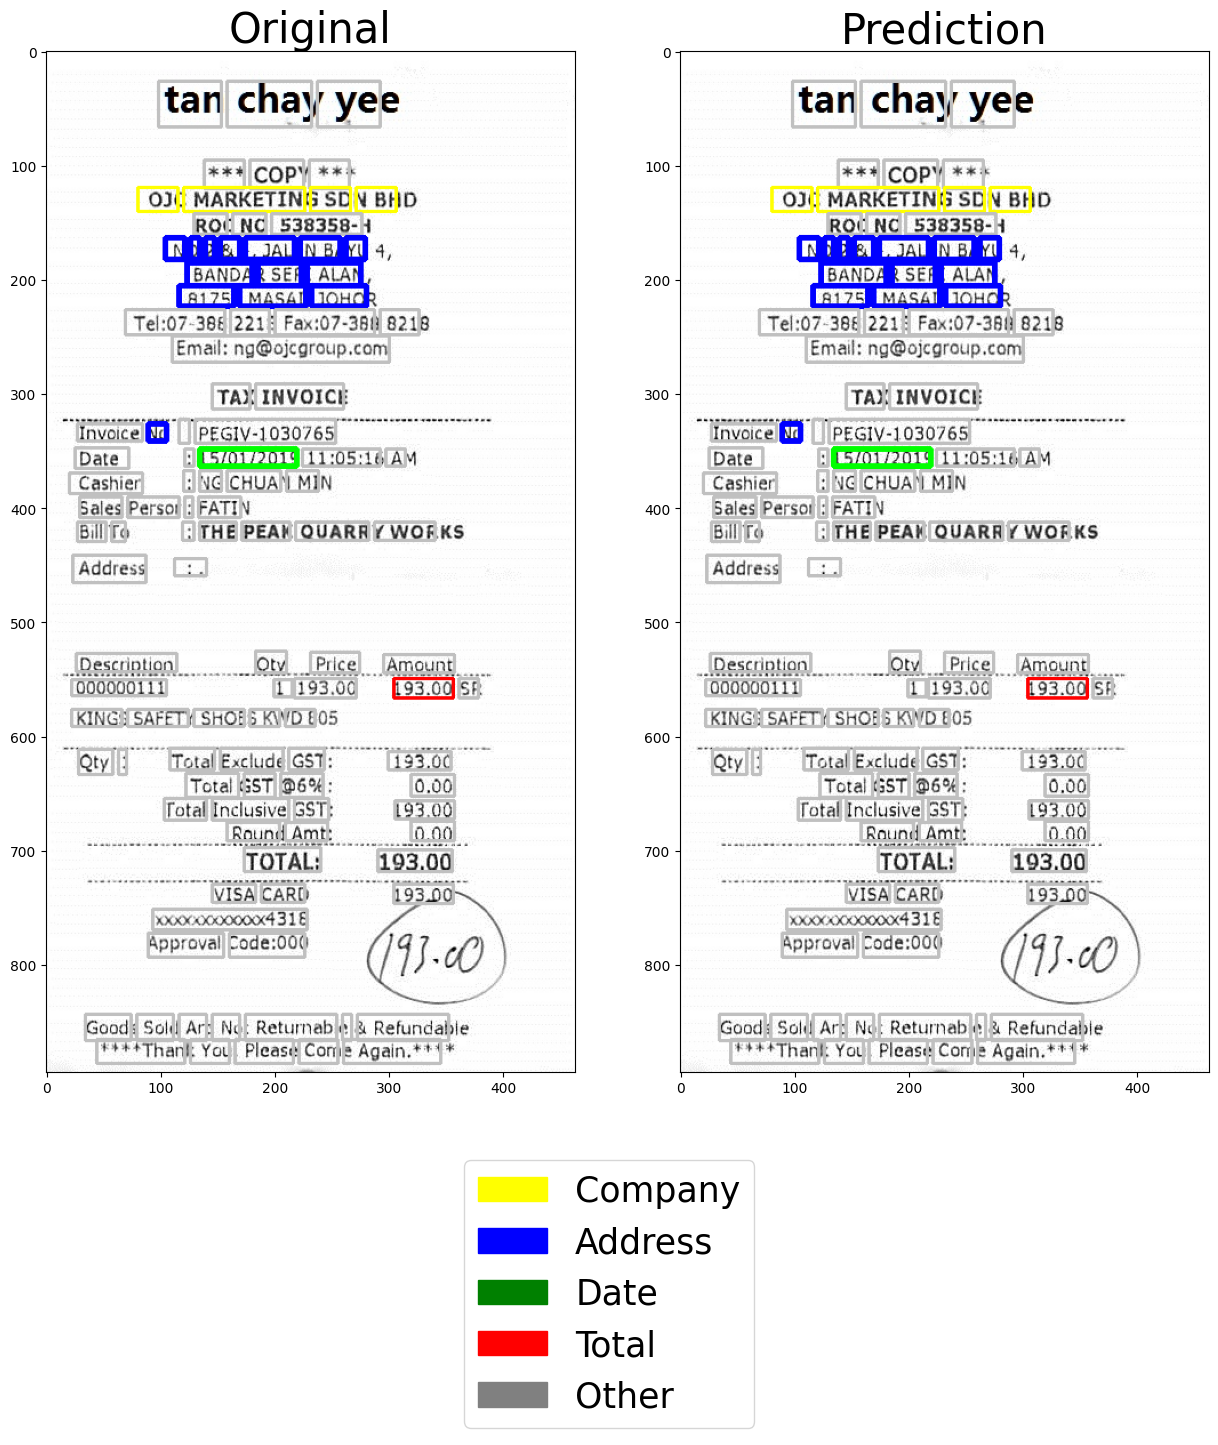

In [25]:
display_prediction(merged_groups[0], 'test')


Filename: X51005444046.jpg
E:\Model\archive\SROIE2019\test\img\X51005444046.jpg


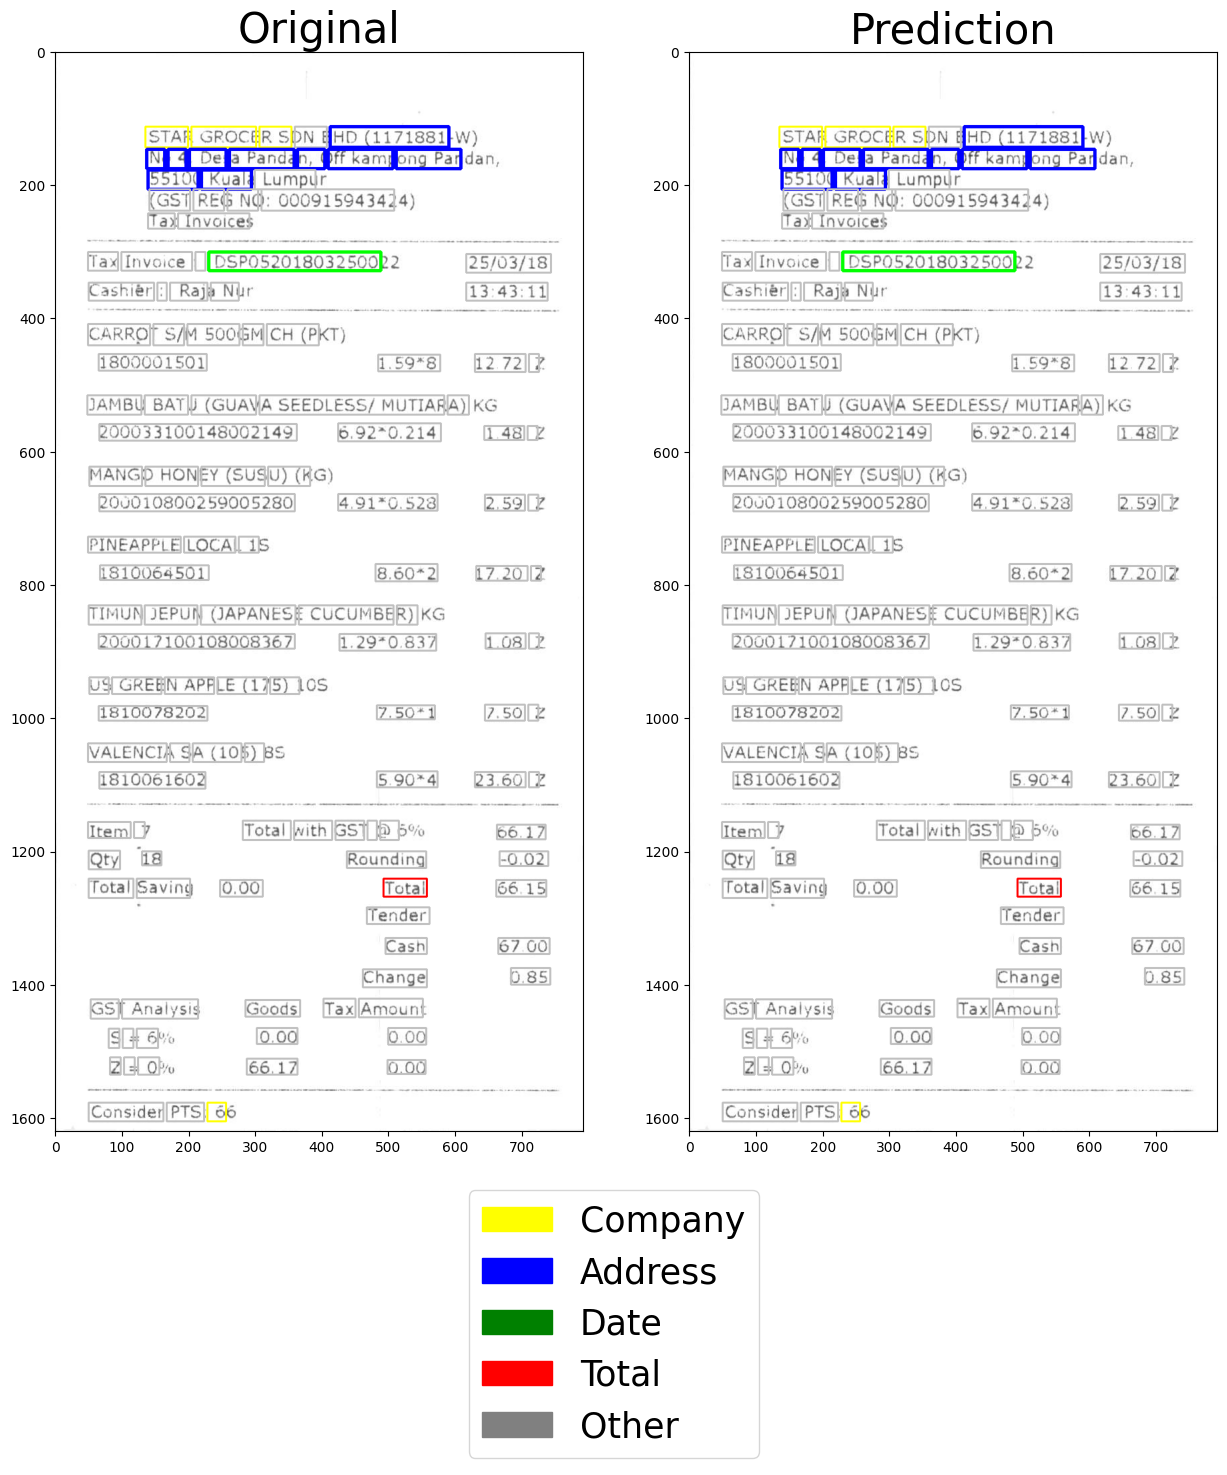

In [26]:


display_prediction(merged_groups[34], 'test')



In [27]:
display_prediction(merged_groups[3], 'test')

Filename: X51005230605.jpg
E:\Model\archive\SROIE2019\test\img\X51005230605.jpg


<h2>You can further check other outputs by following the botton cell</h2>

Filename: X51005230621.jpg
E:\Model\archive\SROIE2019\test\img\X51005230621.jpg


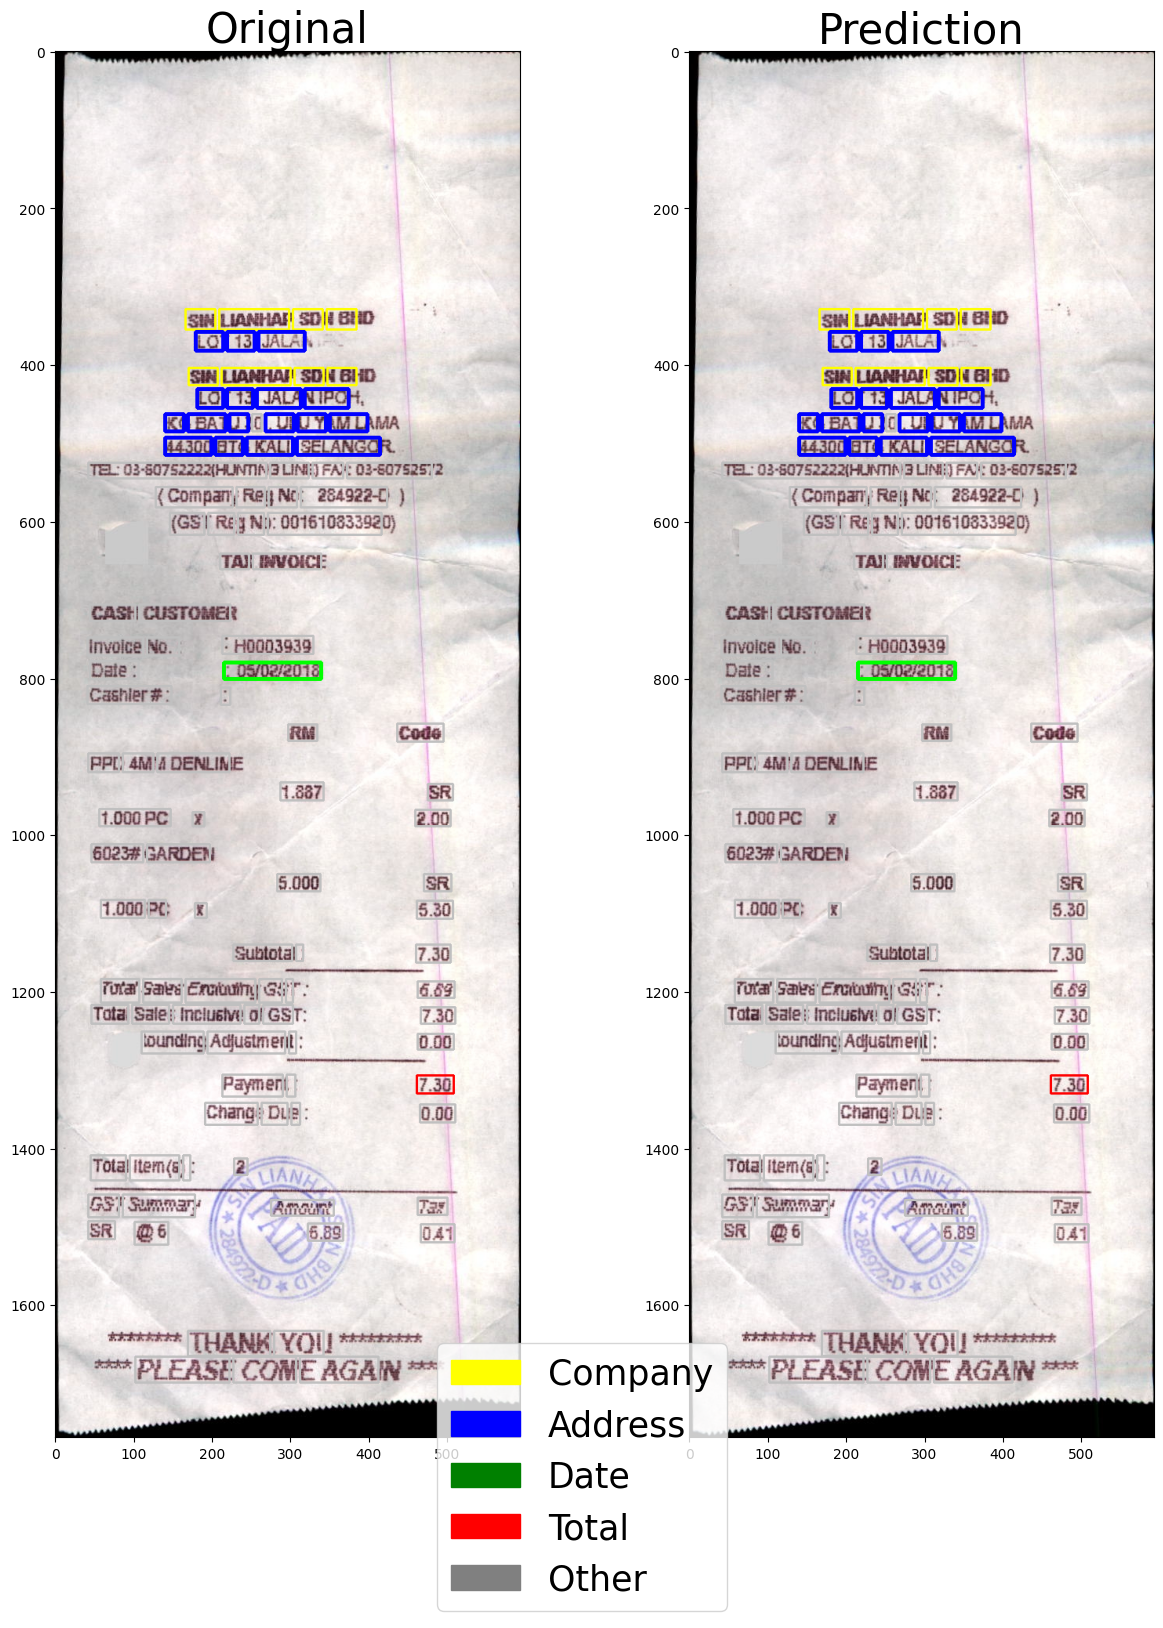

In [28]:
#Try out different values of n to see the predicted output
n = 5
display_prediction(merged_groups[n], 'test')

In [29]:
df = merged_groups[2][1]
df.head()

word             bbox     size         image true_category  \
205   PERNIAGAAN  380 241 498 266  463 776  X51005200931     S-COMPANY   
206        ZHENG  503 241 562 266  463 776  X51005200931     S-COMPANY   
207          HUI  567 241 602 266  463 776  X51005200931     S-COMPANY   
208  JM0326955-V  459 267 546 282  463 776  X51005200931             O   
209        NO.59  416 286 454 301  463 776  X51005200931     S-ADDRESS   

    prediction_category   x0   y0   x2   y2  
205           S-COMPANY  380  241  498  266  
206           S-COMPANY  503  241  562  266  
207           S-COMPANY  567  241  602  266  
208                   O  459  267  546  282  
209           S-ADDRESS  416  286  454  301

In [30]:
df1 = df.drop(['size','image','true_category'], axis = 1)
print(df1)

            word               bbox prediction_category   x0    y0   x2    y2
205   PERNIAGAAN    380 241 498 266           S-COMPANY  380   241  498   266
206        ZHENG    503 241 562 266           S-COMPANY  503   241  562   266
207          HUI    567 241 602 266           S-COMPANY  567   241  602   266
208  JM0326955-V    459 267 546 282                   O  459   267  546   282
209        NO.59    416 286 454 301           S-ADDRESS  416   286  454   301
..           ...                ...                 ...  ...   ...  ...   ...
350          ARE  451 1136 477 1155                   O  451  1136  477  1155
351          NOT  482 1136 508 1155                   O  482  1136  508  1155
352   RETURNABLE  513 1136 602 1155                   O  513  1136  602  1155
353        THANK  450 1160 490 1175                   O  450  1160  490  1175
354         YOU.  495 1160 527 1175                   O  495  1160  527  1175

[150 rows x 7 columns]


In [31]:
csv_data = df1.to_csv()
print(csv_data)

,word,bbox,prediction_category,x0,y0,x2,y2
205,PERNIAGAAN,380 241 498 266,S-COMPANY,380,241,498,266
206,ZHENG,503 241 562 266,S-COMPANY,503,241,562,266
207,HUI,567 241 602 266,S-COMPANY,567,241,602,266
208,JM0326955-V,459 267 546 282,O,459,267,546,282
209,NO.59,416 286 454 301,S-ADDRESS,416,286,454,301
210,JALAN,459 286 497 301,S-ADDRESS,459,286,497,301
211,PERMAS,502 286 548 301,S-ADDRESS,502,286,548,301
212,9/5,553 286 576 301,S-ADDRESS,553,286,576,301
213,BANDAR,404 304 455 320,S-ADDRESS,404,304,455,320
214,BARU,460 304 494 320,S-ADDRESS,460,304,494,320
215,PERMAS,499 304 550 320,S-ADDRESS,499,304,550,320
216,JAYA,555 304 589 320,S-ADDRESS,555,304,589,320
217,81750,427 319 471 338,S-ADDRESS,427,319,471,338
218,JOHOR,476 319 520 338,S-ADDRESS,476,319,520,338
219,BAHRU,525 319 569 338,S-ADDRESS,525,319,569,338
220,TEL:07-386,386 337 467 353,O,386,337,467,353
221,7524,472 337 504 353,O,472,337,504,353
222,FAX:07-386,509 337 590 353,O,509,337,590,353
223,3793,595 337 627 353,O,595,337,6

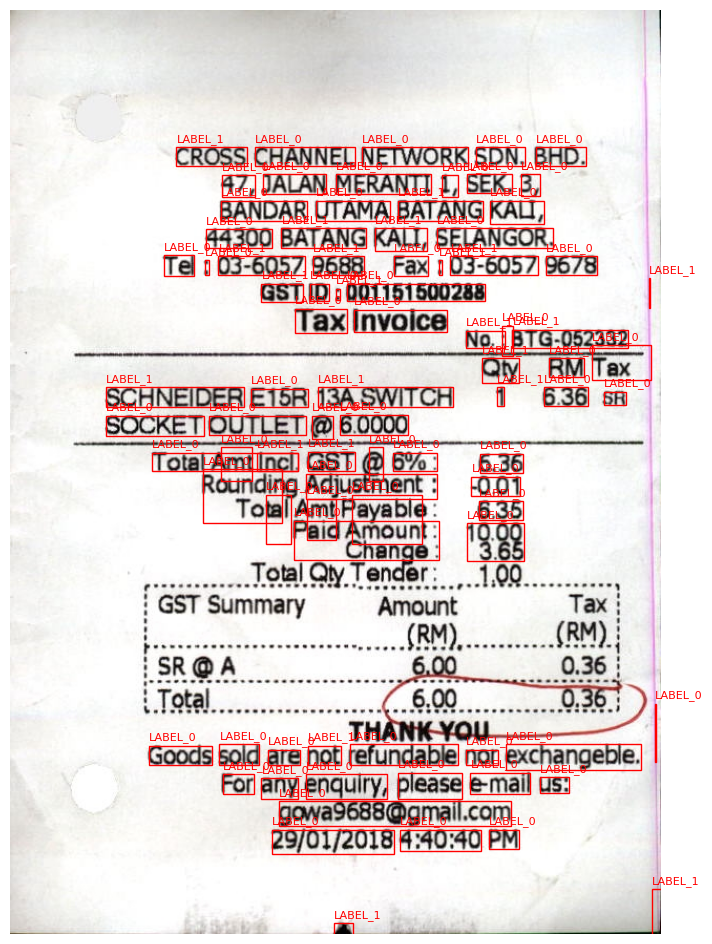

Extracted fields:
LABEL_0: cross channel network sd ##n . b ##hd . 47 , jalan ##ant ##i se ##k . banda ##ma ##ang , ##30 ##0 ##ang selangor . : 60 ##57 96 ##8 ##8 fa ##x : 60 ##57 96 ##7 ##8 gs ##t id : 001 ##15 ##15 ##00 ##28 ##8 tax in ##vo ##ice no . : bt ##g - 05 ##23 ##32 g e ##15 ##r 13 ##as ##wi ##tch 1 63 ##6 sh socket outlet @ 6 . 000 total am ##t inc ##l . gs @ 6 % : 6 . 36 round ##y adjustment : - . 01 al re ##bie 6 . 35 pale ##ghan ##ge : s ##8 ##8 goods sold are not ref ##unda ##ble nor exchange ##ble . for any en ##qui ##ry , please e - mail us : ##wa ##9 ##6 ##8 ##8 @ ##il . com / 01 / 2018 : 40 : pm g
LABEL_1: mer 1 , 3 , ##r uta bat kali 44 bat kali , tel 03 - 03 - | ##ly rm tex schneider ##0 ##t 0 eva | go gma 29 4 40 |


In [56]:
from transformers import LayoutLMTokenizerFast, LayoutLMForTokenClassification
from PIL import Image
import pytesseract
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict

def predict_from_image(image_path, model_dir):
    # 1) Point pytesseract to your install
    pytesseract.pytesseract.tesseract_cmd = r"E:\Tesseract_OCR\tesseract.exe"
    
    # 2) Load model & tokenizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = LayoutLMTokenizerFast.from_pretrained(model_dir)
    model = LayoutLMForTokenClassification.from_pretrained(model_dir).to(device)
    model.eval()

    # 3) OCR
    image = Image.open(image_path).convert("RGB")
    w_img, h_img = image.size
    ocr = pytesseract.image_to_data(image, output_type=pytesseract.Output.DICT)
    words, boxes = [], []
    for i, word in enumerate(ocr["text"]):
        if word.strip():
            x, y, w, h = ocr["left"][i], ocr["top"][i], ocr["width"][i], ocr["height"][i]
            words.append(word)
            boxes.append([x, y, x + w, y + h])

    # 4) Normalize boxes
    norm_boxes = [
        [int(x0 * 1000 / w_img), int(y0 * 1000 / h_img), int(x1 * 1000 / w_img), int(y1 * 1000 / h_img)]
        for x0, y0, x1, y1 in boxes
    ]

    # 5) Tokenize (keep BatchEncoding)
    enc = tokenizer(
        words,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=512,
        is_split_into_words=True
    )
    # extract word_ids BEFORE moving to device
    word_ids = enc.word_ids(batch_index=0)

    # move tensors
    enc = {k: v.to(device) for k, v in enc.items()}

    # 6) Build bbox tensor aligned to tokens
    token_boxes = [
        norm_boxes[word_idx] if word_idx is not None else [0, 0, 0, 0]
        for word_idx in word_ids
    ]
    enc["bbox"] = torch.tensor([token_boxes], dtype=torch.long).to(device)

    # 7) Model inference
    with torch.no_grad():
        out = model(**enc)
    pred_ids = out.logits[0].argmax(-1).cpu().tolist()
    id2label = model.config.id2label
    tokens = tokenizer.convert_ids_to_tokens(enc["input_ids"][0])

    # 8) Decode results
    results = defaultdict(list)
    for token, pred in zip(tokens, pred_ids):
        label = id2label[pred]
        if label != "O" and token not in tokenizer.all_special_tokens:
            results[label].append(token)

    # 9) Visualize
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(image)
    for (x0, y0, x1, y1), pred in zip(boxes, pred_ids):
        label = id2label[pred]
        if label != "O":
            ax.add_patch(patches.Rectangle((x0, y0), x1-x0, y1-y0,
                                           edgecolor="red", facecolor="none", linewidth=1))
            ax.text(x0, y0-5, label, color="red", fontsize=8)
    ax.axis("off")
    plt.show()

    # 10) Return aggregated fields
    return {lbl: " ".join(tok_list) for lbl, tok_list in results.items()}

# ─── Run and print ───
fields = predict_from_image(
    image_path="E:/Model/t.jpg",
    model_dir="E:/Model/my_saved_layoutlm"
)
print("Extracted fields:")
for k, v in fields.items():
    print(f"{k}: {v}")
